# Event Selection

**_must run with dfs will all reconstructed slices_**

This notebook runs the full event selection, evaluating selection performance

- runs cosmic rejection and optimized cuts from `inspect_variables.ipynb`
- makes mode breakdown bar plots for each selection stage
- makes purity/efficiency summary plots

In [ ]:
%load_ext autoreload
%autoreload 2

#print all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import sys
from os import path
from tqdm import tqdm

# local imports
sys.path.append('../../')
from analysis_village.numucc1p0pi.selection_definitions import *
from variable_configs import VariableConfig
from pyanalib.split_df_helpers import *
from pyanalib.stat_helpers import *
from makedf.constants import *
from pyanalib.variable_calculator import get_cc1p0pi_tki
from pyanalib.pandas_helpers import pad_column_name

plt.style.use("presentation.mplstyle")
# cmap = mpl.cm.viridis
# norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [ ]:
save_fig = False
save_fig_dir = "/exp/sbnd/data/users/munjung/plots/numucc1p0pi/event_selection"

In [ ]:
# KE <-> p conversion for providing the sig threshold in terms of KE in technote
def p_to_KE(p, mass):
    return np.sqrt(p**2 + mass**2) - mass

p_to_KE(0.220, MUON_MASS)
p_to_KE(1, MUON_MASS)
p_to_KE(0.300, PROTON_MASS)
p_to_KE(1, PROTON_MASS)

0.43298813067688946

# Load dataframes

- these should be dfs w/o any selection applied

In [ ]:
file_dir = "/exp/sbnd/data/users/munjung/xsec/NuINT2025"
## -- MC 
# mc_file = path.join(file_dir, "MC_bnb_cosmics_aa_nosel.df")
mc_file = path.join(file_dir, "MC_bnb_cosmics_nosel_slc.df")
mc_split_df = pd.read_hdf(mc_file, key="split")
mc_n_split = get_n_split(mc_file)
print("mc_n_split: %d" %(mc_n_split))
print_keys(mc_file)

## -- Data
data_file = path.join(file_dir, "Data_dev_nosel.df")
data_split_df = pd.read_hdf(data_file, key="split")
data_n_split = get_n_split(data_file)
print("data_n_split: %d" %(data_n_split))
print_keys(data_file)

# data_hdr_file = path.join(file_dir, "Data_dev_2prong.df")
# data_hdr_df = pd.read_hdf(data_hdr_file, key="split")
# data_n_split = get_n_split(data_hdr_file)
# print("data_n_split: %d" %(data_n_split))
# print_keys(data_hdr_file)


mc_n_split: 81
Keys: ['/evt_0', '/evt_1', '/evt_10', '/evt_11', '/evt_12', '/evt_13', '/evt_14', '/evt_15', '/evt_16', '/evt_17', '/evt_18', '/evt_19', '/evt_2', '/evt_20', '/evt_21', '/evt_22', '/evt_23', '/evt_24', '/evt_25', '/evt_26', '/evt_27', '/evt_28', '/evt_29', '/evt_3', '/evt_30', '/evt_31', '/evt_32', '/evt_33', '/evt_34', '/evt_35', '/evt_36', '/evt_37', '/evt_38', '/evt_39', '/evt_4', '/evt_40', '/evt_41', '/evt_42', '/evt_43', '/evt_44', '/evt_45', '/evt_46', '/evt_47', '/evt_48', '/evt_49', '/evt_5', '/evt_50', '/evt_51', '/evt_52', '/evt_53', '/evt_54', '/evt_55', '/evt_56', '/evt_57', '/evt_58', '/evt_59', '/evt_6', '/evt_60', '/evt_61', '/evt_62', '/evt_63', '/evt_64', '/evt_65', '/evt_66', '/evt_67', '/evt_68', '/evt_69', '/evt_7', '/evt_70', '/evt_71', '/evt_72', '/evt_73', '/evt_74', '/evt_75', '/evt_76', '/evt_77', '/evt_78', '/evt_79', '/evt_8', '/evt_80', '/evt_9', '/hdr_0', '/hdr_1', '/hdr_10', '/hdr_11', '/hdr_12', '/hdr_13', '/hdr_14', '/hdr_15', '/hdr_16', 

In [ ]:
# concat dfs 
n_max_concat = 10

mc_keys2load = ['hdr', 'evt'] #, 'trk'] # 'mcnu', 
mc_dfs = load_dfs(mc_file, mc_keys2load, n_max_concat=n_max_concat)
mc_hdr_df = mc_dfs['hdr']
mc_evt_df = mc_dfs['evt']
# mc_trk_df = mc_dfs['trk']
# mc_mcnu_df = mc_dfs['mcnu']

data_keys2load = ['hdr', 'evt', 'trk']
data_dfs = load_dfs(data_file, data_keys2load, n_max_concat=n_max_concat)
data_hdr_df = data_dfs['hdr']
data_evt_df = data_dfs['evt']
data_trk_df = data_dfs['trk']

# data_keys2load = ['hdr']
# data_dfs = load_dfs(data_hdr_file, data_keys2load, n_max_concat=n_max_concat)
# data_hdr_df = data_dfs['hdr']

KeyError: 'No object named trk_0 in the file'

In [ ]:
# print(data_hdr_df.TOR860.sum())
# print(data_hdr_df.TOR875.sum())

In [ ]:
## total pot - scale to data POT

# BNB data
# data_tot_pot = data_hdr_df['TOR875'].sum()
data_tot_pot = data_hdr_df['pot'].sum()
# data_tot_pot = 4.60e+18
print("data_tot_pot: %.3e" %(data_tot_pot))
pot_str = "7.37 $\\times 10^{18}$"
data_evt_df["pot_weight"] = np.ones(len(data_evt_df))
data_trk_df["pot_weight"] = np.ones(len(data_trk_df))
data_gates = data_hdr_df.nbnbinfo.sum()
print("data tot gates : %.3e" %(data_gates))

# BNB MC
mc_tot_pot = mc_hdr_df['pot'].sum()
print("mc_tot_pot: %.3e" %(mc_tot_pot))
mc_pot_scale = data_tot_pot / mc_tot_pot
print("mc_pot_scale: %.3e" %(mc_pot_scale))

mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))
mc_trk_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_trk_df))

# Intime Data
basepath = "/exp/sbnd/data/users/munjung/xsec/2025B"
fname = "trash/Data_intime_1000.df"
intime_hdr_df = pd.read_hdf(path.join(basepath, fname), "hdr")
intime_evt_df = pd.read_hdf(path.join(basepath, fname), "slc")
intime_trk_df = pd.read_hdf(path.join(basepath, fname), "trk")

# intime_gates = intime_hdr.noffbeambnb.sum()
intime_gates = intime_hdr_df[intime_hdr_df['first_in_subrun'] == 1]['noffbeambnb'].sum()
print("intime cosmics data gates: {:.2e}".format(intime_gates))
f = 0.073
scale_intime_to_lightdata = (1-f)*data_gates/intime_gates
print("goal scale: {:.2f}".format(scale_intime_to_lightdata))
intime_evt_df["gates_weight"] = scale_intime_to_lightdata * np.ones(len(intime_evt_df))
intime_trk_df["gates_weight"] = scale_intime_to_lightdata * np.ones(len(intime_trk_df))

data_tot_pot: 7.370e+18
data tot gates : 1.561e+06
mc_tot_pot: 1.504e+19
mc_pot_scale: 4.900e-01
intime cosmics data gates: 2.34e+06
goal scale: 0.62


In [ ]:
# calculate TKI vars
# TODO: do this when making the dfs
# P_mu_col = pad_column_name(("totp",), mc_evt_df.mu)
# P_p_col = pad_column_name(("totp",), mc_evt_df.p)
# mc_ret_tki = get_cc1p0pi_tki(mc_evt_df.mu, mc_evt_df.p, P_mu_col, P_p_col)

# mc_evt_df['del_Tp'] = mc_ret_tki['del_Tp']
# mc_evt_df['del_Tp_x'] = mc_ret_tki['del_Tp_x']
# mc_evt_df['del_Tp_y'] = mc_ret_tki['del_Tp_y']
# # mc_evt_df['del_Lp'] = mc_ret_tki['del_Lp']
# mc_evt_df['del_p'] = mc_ret_tki['del_p']
# mc_evt_df['del_alpha'] = mc_ret_tki['del_alpha']
# mc_evt_df['del_phi'] = mc_ret_tki['del_phi']
# # mc_evt_df['R'] = mc_ret_tki['R']

# Plotter

In [ ]:
# nu_cosmics_labels = ["Cosmic", r"Out-FV $\nu$", r"FV $\nu$"]
# # nu_cosmics_colors = ["#ED5564", "#FFCE54", "#A0D568"]
# nu_cosmics_colors = ["gray", "C0", "C1"]

# topology_labels = ["Cosmic", r"Out-FV $\nu$", r"FV other $\nu$", r"FV $\nu_{\mu}$ NC",  
#                   r"FV $\nu_{\mu}$ CC Other", r"FV $\nu_{\mu}$ CC Np0$\pi$", r"FV $\nu_{\mu}$ CC 1p0$\pi$"]
# topology_colors = ["gray", "sienna", "crimson", "darkgreen", 
#                   "coral", "darkslateblue", "mediumslateblue"]

# genie_labels = ["Cosmic", r"Out-FV $\nu$", r"FV $\nu$ Other", r"FV $\nu_{\mu}$ NC",
#                 r"FV $\nu_{\mu}$ CC Other", r"FV $\nu_{\mu}$ CC DIS",
#                 r"FV $\nu_{\mu}$ CC RES", r"FV $\nu_{\mu}$ CC MEC",
#                 r"FV $\nu_{\mu}$ CC QE"]
# genie_colors = ["gray", "sienna", "crimson", "darkgreen",
#                 "#BFB17C", "#D88A3B", "#2c7c94",
#                 "#390C1E", "#9b5580"]

In [ ]:
def hist_plot(plot_type,
              evtdf, vardf, 
              vardf_data, var_intime,
              bins,
              plot_labels=["", "", ""],
              ratio = True,
              vline = None,
              save_fig=False, save_name=None): 

    assert len(evtdf) == len(vardf)

    if plot_type == "nu_cosmics":
        labels = nu_cosmics_labels
        colors = nu_cosmics_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv = IsNuInFV(evtdf)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv]

    elif plot_type == "topology":
        labels = topology_labels[::-1]
        colors = topology_colors[::-1]

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv_nu_other = IsNuInFV_NuOther(evtdf)
        cut_nu_infv_numu_nc = IsNuInFV_NumuNC(evtdf)
        cut_nu_infv_numu_cc_other = IsNuInFV_NumuCC_Other(evtdf)
        cut_nu_infv_numu_cc_np0pi = IsNuInFV_NumuCC_Np0pi(evtdf)
        cut_nu_infv_numu_cc_1p0pi = IsNuInFV_NumuCC_1p0pi(evtdf)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv_nu_other, cut_nu_infv_numu_nc, 
                cut_nu_infv_numu_cc_other, cut_nu_infv_numu_cc_np0pi, cut_nu_infv_numu_cc_1p0pi]

    elif plot_type == "genie":
        labels = genie_mode_labels[::-1]
        colors = genie_mode_colors[::-1]

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv_nu_other = IsNuInFV_NuOther(evtdf)
        cut_nu_infv_numu_nc = IsNuInFV_NumuNC(evtdf)
        print("numu NC", cut_nu_infv_numu_nc.sum())
        # cut_nu_infv_numu_coh = IsNuInFV_NumuCC_COH(evtdf)
        cut_nu_infv_numu_othermode = IsNuInFV_NumuCC_OtherMode(evtdf)
        cut_nu_infv_numu_cc_dis = IsNuInFV_NumuCC_DIS(evtdf)
        cut_nu_infv_numu_cc_res = IsNuInFV_NumuCC_RES(evtdf)
        cut_nu_infv_numu_cc_me = IsNuInFV_NumuCC_MEC(evtdf)
        cut_nu_infv_numu_cc_qe = IsNuInFV_NumuCC_QE(evtdf)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv_nu_other, cut_nu_infv_numu_nc, 
                cut_nu_infv_numu_othermode, cut_nu_infv_numu_cc_dis, cut_nu_infv_numu_cc_res, 
                cut_nu_infv_numu_cc_me, cut_nu_infv_numu_cc_qe]
        

    else:
        raise ValueError("Invalid plot_type: %s, please choose between [nu_cosmics, topolgy, or genie]" % plot_type)

    # --- Plot template
    if ratio:
        fig, axs = plt.subplots(2, 1, figsize=(8.5, 8), 
                               sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        fig.subplots_adjust(hspace=0.05)
        ax = axs[0]
        ax_r = axs[1]
    else:
        fig, ax = plt.subplots()

    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # --- Data
    total_data, bins = np.histogram(vardf_data, bins=bins)
    data_eylow, data_eyhigh = return_data_stat_err(total_data)
    ax.errorbar(bin_centers, total_data, yerr=np.vstack((data_eylow, data_eyhigh)), 
                fmt='o', color='black')

    # --- MC
    # collect all MC + intime
    var_categ = [var_intime] + [vardf[i] for i in cuts]
    scale_mc = evtdf.pot_weight.unique()[0]
    # TODO:
    scale_intime = scale_intime_to_lightdata
    weights_categ = [scale_intime*np.ones_like(var_intime)] + [scale_mc*np.ones_like(vardf[i]) for i in cuts] 
    colors = ["black"] + colors
    labels = ["Cosmic\n(In-time)"] + labels

    mc_stack, _, _ = ax.hist(var_categ,
                                bins=bins,
                                weights=weights_categ,
                                stacked=True,
                                color=colors,
                                label=labels,
                                edgecolor='none',
                                linewidth=0,
                                density=False,
                                histtype='stepfilled')


    # ---- MC stat err
    each_mc_hist_data = []
    each_mc_hist_err2 = []  # sum of squared weights for error

    for data, w in zip(var_categ, weights_categ):
        hist_vals, _ = np.histogram(data, bins=bins, weights=w)
        hist_err2, _ = np.histogram(data, bins=bins, weights=np.square(w))
        each_mc_hist_data.append(hist_vals)
        each_mc_hist_err2.append(hist_err2)

    total_mc = np.sum(each_mc_hist_data, axis=0)
    total_mc_err2 = np.sum(each_mc_hist_err2, axis=0)
    mc_stat_err = np.sqrt(total_mc_err2)

    ax.bar(
       bin_centers,
        2 * mc_stat_err,
        width=np.diff(bins),
        bottom=total_mc - mc_stat_err,
        facecolor='none',             # transparent fill
        edgecolor='dimgray',            # outline color of the hatching
        hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
        linewidth=0.0,
        label='MC Stat. Unc.'
    )


    ax.set_xlim(bins[0], bins[-1])
    if ratio == False: # only plot xlabel if we're not plotting the ratio panel
        ax_r.set_xlabel(plot_labels[0])
    ax.set_ylabel(plot_labels[1])

    if vline is not None:
        ax.axvline(x=vline, color='red', linestyle='--')


    if ratio:
        # MC stat err
        mc_stat_err_ratio = mc_stat_err / total_mc
        mc_content_ratio = total_mc / total_mc
        mc_stat_err_ratio = np.nan_to_num(mc_stat_err_ratio, nan=0.)
        mc_content_ratio = np.nan_to_num(mc_content_ratio, nan=-999.)
        ax_r.bar(
            bin_centers,
            2*mc_stat_err_ratio,
            width=np.diff(bins),
            bottom=mc_content_ratio - mc_stat_err_ratio,
            facecolor='none',             # transparent fill
            edgecolor='dimgray',          # outline color of the hatching
            hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
            linewidth=0.0,
            label='MC Stat. Unc.'
        )

        # data/MC ratio err
        data_ratio = total_data / total_mc
        data_ratio_eylow = data_eylow / total_mc
        data_ratio_eyhigh = data_eyhigh / total_mc
        data_ratio = np.nan_to_num(data_ratio, nan=-999.)
        data_ratio_eylow = np.nan_to_num(data_ratio_eylow, nan=0.)
        data_ratio_eyhigh = np.nan_to_num(data_ratio_eyhigh, nan=0.)
        
        #data_ratio_errors = data_ratio_eylow + data_ratio_eyhigh
        #ax_ratio.errorbar(bin_centers, data_ratio, yerr=data_ratio_errors,
        #                 fmt='o', color='black', label='Data',
        #                 markersize=5, capsize=3, linewidth=1.5)

        ax_r.errorbar(bin_centers, data_ratio,
                  yerr=np.vstack((data_ratio_eylow, data_ratio_eyhigh)),
                  fmt='o', color='black')
                #   , label='Data')
                #   markersize=5, capsize=3, linewidth=1.5)
        
        # if highest value is greater than 2.0, set ylim to 2.0
        if np.max(data_ratio) > 2.0:
            ax_r.set_ylim(0., 2.0)

        ax_r.axhline(1.0, color='red', linestyle='--', linewidth=1)
        
        ax_r.grid(True)
        ax_r.minorticks_on()
        ax_r.grid(which='minor', linestyle=':', linewidth=0.5, color='gray', alpha=0.5)

        ax_r.set_xlabel(plot_labels[0])
        ax_r.set_ylabel("Data/MC")

    # --- Legend
    accum_sum = [np.sum(data) for data in mc_stack]
    accum_sum = [0.] + accum_sum
    total_sum = accum_sum[-1]
    individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
    fractions = [(count / total_sum) * 100 for count in individual_sums]
    legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(labels[::-1], fractions[::-1])]
    legend_labels += ["Data", "MC Stat. Unc."]
    leg = ax.legend(legend_labels, 
                    loc='upper left', 
                    fontsize=10, 
                    frameon=False, 
                    ncol=3, 
                    bbox_to_anchor=(0.02, 0.98))
    leg_height = leg.get_bbox_to_anchor().height
    max_data_with_err = np.max(total_data + data_eyhigh)
    # ax.set_ylim(0., 1.05 * max_data_with_err + leg_height)
    ax.set_ylim(0., 1.4 * max_data_with_err)

    if save_fig:
        plt.savefig(save_name, bbox_inches='tight') #, dpi=300)
    plt.show()

    # bolder figure lines?
    # ax.tick_params(width=2, length=10)
    # for spine in ax.spines.values():
    #     spine.set_linewidth(2)
    
    ret_dict = {"cuts": cuts}
    return ret_dict

In [ ]:
def bar_plot(type,
             evtdf,
             plot_labels=["", "", ""],
             save_fig=False, save_name=None): #, scale, stage):

    if type == "nu_cosmics":
        ncateg = 3
        labels = nu_cosmics_labels
        colors = nu_cosmics_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_intfv = IsNu(evtdf) & InFV(evtdf.slc.truth.position)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_intfv]

    elif type == "topology":
        ncateg = 7
        labels = topology_labels[::-1]
        colors = topology_colors[::-1]

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv_nu_other = IsNuInFV_NuOther(evtdf)
        cut_nu_infv_numu_nc = IsNuInFV_NumuNC(evtdf)
        cut_nu_infv_numu_cc_other = IsNuInFV_NumuCC_Other(evtdf)
        cut_nu_infv_numu_cc_np0pi = IsNuInFV_NumuCC_Np0pi(evtdf)
        cut_nu_infv_numu_cc_1p0pi = IsNuInFV_NumuCC_1p0pi(evtdf)

        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv_nu_other, cut_nu_infv_numu_nc, 
                cut_nu_infv_numu_cc_other, cut_nu_infv_numu_cc_np0pi, cut_nu_infv_numu_cc_1p0pi]

    elif type == "genie":
        ncateg = 9
        labels = genie_mode_labels[::-1]
        colors = genie_mode_colors[::-1]

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv_nu_other = IsNuInFV_NuOther(evtdf)
        cut_nu_infv_numu_nc = IsNuInFV_NumuNC(evtdf)
        # cut_nu_infv_numu_coh = IsNuInFV_NumuCC_COH(evtdf)
        cut_nu_infv_numu_othermode = IsNuInFV_NumuCC_OtherMode(evtdf)
        cut_nu_infv_numu_cc_dis = IsNuInFV_NumuCC_DIS(evtdf)
        cut_nu_infv_numu_cc_res = IsNuInFV_NumuCC_RES(evtdf)
        cut_nu_infv_numu_cc_me = IsNuInFV_NumuCC_MEC(evtdf)
        cut_nu_infv_numu_cc_qe = IsNuInFV_NumuCC_QE(evtdf)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv_nu_other, cut_nu_infv_numu_nc, 
                cut_nu_infv_numu_othermode, cut_nu_infv_numu_cc_dis, cut_nu_infv_numu_cc_res, 
                cut_nu_infv_numu_cc_me, cut_nu_infv_numu_cc_qe]

    else:
        raise ValueError("Invalid type: %s, please choose between [nu_cosmics, topolgy, or genie]" % type)


    fig, ax = plt.subplots(figsize = (6, ncateg*0.6))

    scale = evtdf.pot_weight.unique()[0]
    size = [scale*len(evtdf[i]) for i in cuts]

    # # make sure that the categories don't overlap
    # for i in range(len(cuts)):
    #     for j in range(i+1, len(cuts)):
    #         if (cuts[i] & cuts[j]).sum() > 0:
    #             print("Categories overlap:", labels[i], labels[j])
    # # and check if the categories cover all events
    # if not np.array(size).sum() == len(evtdf):
    #     print("Categories do not cover all events")
    #     print("Total events:", len(evtdf))
    #     print("Sum of categories:", np.array(size).sum())

    bars = plt.barh(labels, size, align='center', color = colors)
    tot_count = np.array(size).sum()
    
    perc_list = []
    for bar in bars:
        width = bar.get_width()
        label_y_pos = bar.get_y() + bar.get_height() / 2
        perc = 100*(width+0.)/(tot_count+0.)
        ax.text(width+1, label_y_pos, s= ("%0.1f"%(100*(width+0.)/(tot_count+0.)) + "%"), va='center')
        perc_list.append(perc)

    plt.xlabel(plot_labels[0])
    plt.xlim(0, 1.12 * np.max(size))

    if save_fig:
        plt.savefig(save_name, bbox_inches="tight")

    ret_dict = {"cuts": cuts,
                "perc_list": perc_list}
    return ret_dict

In [ ]:
plot_labels_bar = ["Events (POT={})".format(pot_str), "", ""]
plot_labels_hist = ["", "Events (POT={})".format(pot_str), ""]

In [ ]:
nu_cosmics_labels

['Cosmic', 'Out-FV $\\nu$', 'FV $\\nu$']

# Collect Through Selection for Summary Plots

In [ ]:
df_dict = {} # for efficiency plot
df_dict_data = {} # for efficiency plot
df_dict_intime = {} # for efficiency plot
perc_dict_topo = {} # for topo break-down plot
perc_dict_genie = {} # for genie break-down plot

# Cosmic Rejection with Slice Variables

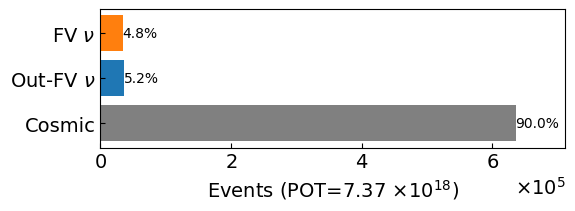

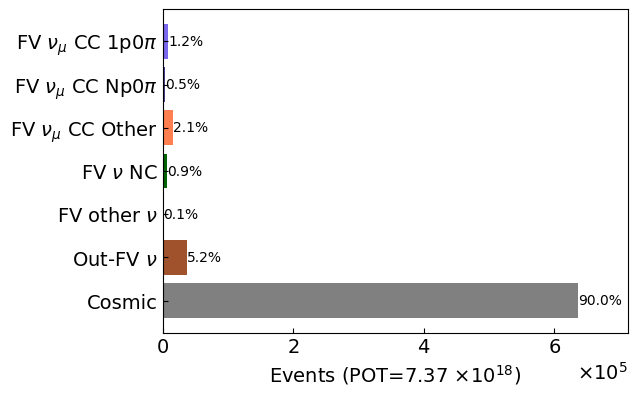

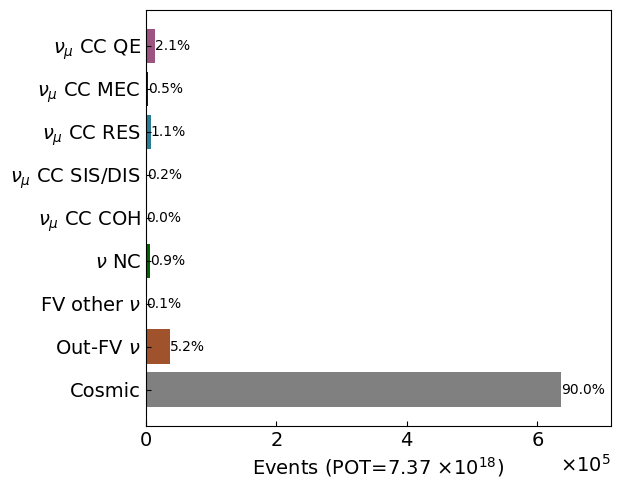

In [ ]:
stage_key = "allreco"
bar_type = "nu_cosmics"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_nu_cosmics = bar_plot(type=bar_type, evtdf=mc_evt_df,
                          plot_labels=plot_labels_bar,
                          save_fig=save_fig, save_name=save_name)

bar_type = "topology"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df,
                          plot_labels=plot_labels_bar,
                          save_fig=save_fig, save_name=save_name)

bar_type = "genie"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df,
                          plot_labels=plot_labels_bar,
                          save_fig=save_fig, save_name=save_name)

df_dict[stage_key] = mc_evt_df
df_dict_data[stage_key] = data_evt_df
df_dict_intime[stage_key] = intime_evt_df
perc_dict_topo[stage_key] = ret_topo["perc_list"]
perc_dict_genie[stage_key] = ret_genie["perc_list"]

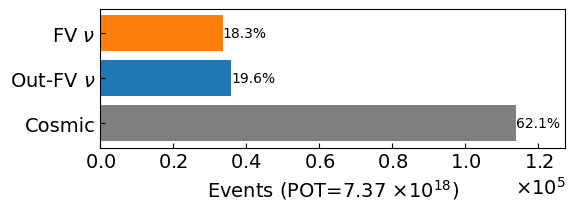

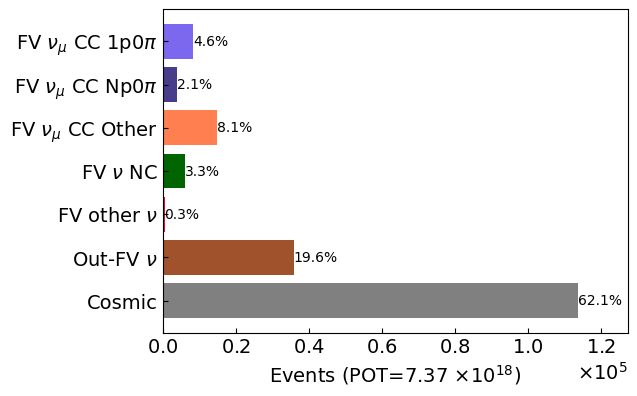

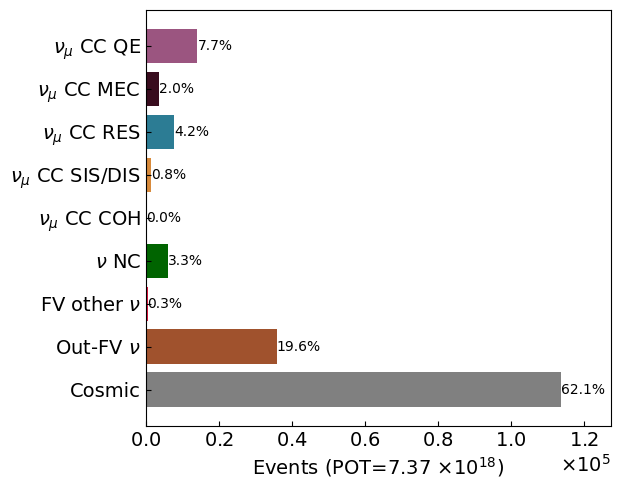

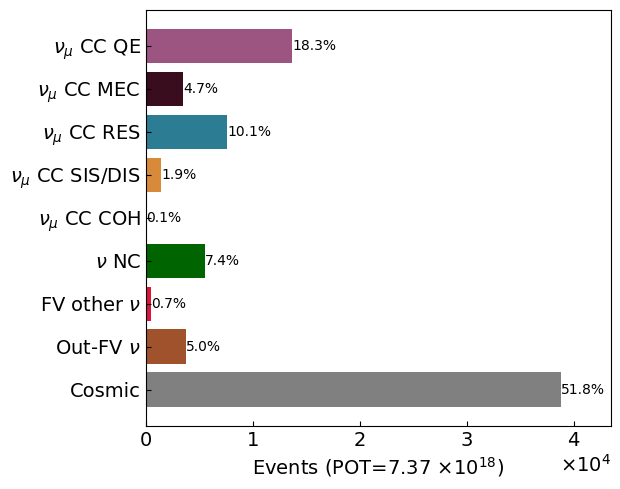

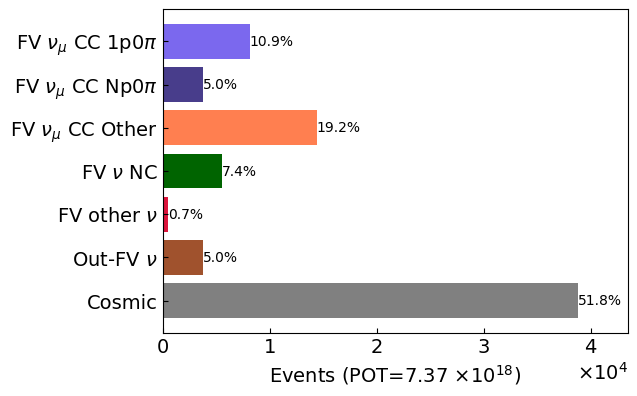

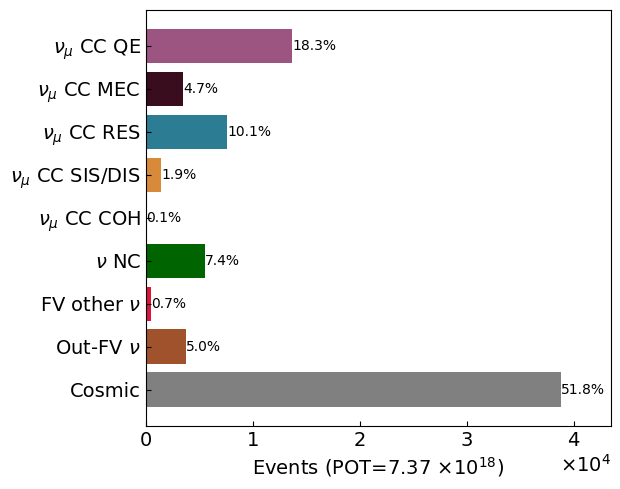

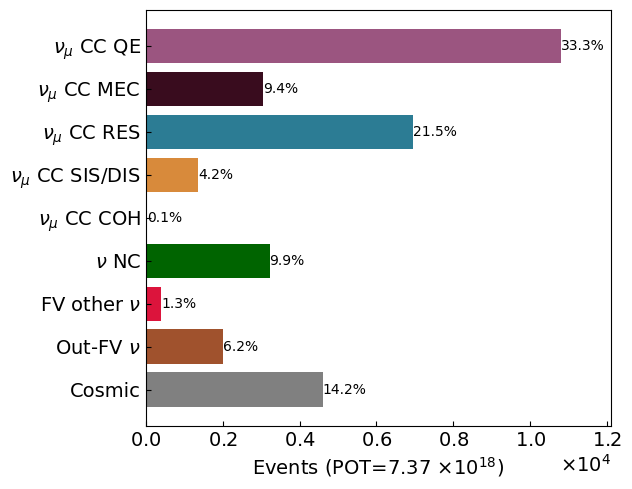

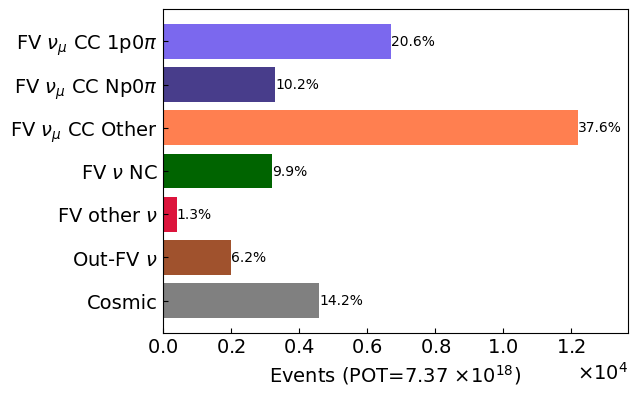

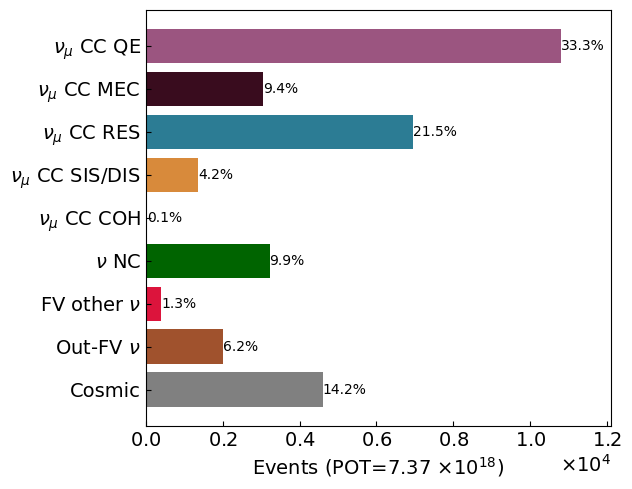

In [ ]:
# is_clear_cosmic cut
stage_key = "is_clear_cosmic"
mc_evt_df_precut = mc_evt_df[mc_evt_df.slc.is_clear_cosmic == 0]
data_evt_df_precut = data_evt_df[data_evt_df.slc.is_clear_cosmic == 0]
intime_evt_df_precut = intime_evt_df[intime_evt_df.slc.is_clear_cosmic == 0]

bar_type = "nu_cosmics"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_nu_cosmics = bar_plot(type=bar_type, evtdf=mc_evt_df_precut,
                          plot_labels=plot_labels_bar,
                          save_fig=save_fig, save_name=save_name)

bar_type = "topology"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_precut,
                          plot_labels=plot_labels_bar,
                          save_fig=save_fig, save_name=save_name)

bar_type = "genie"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_precut,
                          plot_labels=plot_labels_bar,
                          save_fig=save_fig, save_name=save_name)

df_dict[stage_key] = mc_evt_df_precut
df_dict_data[stage_key] = data_evt_df_precut
df_dict_intime[stage_key] = intime_evt_df_precut
perc_dict_topo[stage_key] = ret_topo["perc_list"]
perc_dict_genie[stage_key] = ret_genie["perc_list"]

# vertex cut
stage_key = "vertex_in_fv"
mc_evt_df_precut = mc_evt_df_precut[InFV(mc_evt_df_precut.slc.vertex)]
data_evt_df_precut = data_evt_df_precut[InFV(data_evt_df_precut.slc.vertex)]
intime_evt_df_precut = intime_evt_df_precut[InFV(intime_evt_df_precut.slc.vertex)]
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_nu_cosmics = bar_plot(type=bar_type, evtdf=mc_evt_df_precut,
                          plot_labels=plot_labels_bar,
                          save_fig=save_fig, save_name=save_name)

bar_type = "topology"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_precut,
                          plot_labels=plot_labels_bar,
                          save_fig=save_fig, save_name=save_name)

bar_type = "genie"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_precut,
                          plot_labels=plot_labels_bar,
                          save_fig=save_fig, save_name=save_name)

df_dict[stage_key] = mc_evt_df_precut
df_dict_data[stage_key] = data_evt_df_precut
df_dict_intime[stage_key] = intime_evt_df_precut
perc_dict_topo[stage_key] = ret_topo["perc_list"]
perc_dict_genie[stage_key] = ret_genie["perc_list"]


# nu-score cut
stage_key = "nu_score"
nu_score_th = 0.5
mc_evt_df_precut = mc_evt_df_precut[mc_evt_df_precut.slc.nu_score > nu_score_th]
data_evt_df_precut = data_evt_df_precut[data_evt_df_precut.slc.nu_score > nu_score_th]
intime_evt_df_precut = intime_evt_df_precut[intime_evt_df_precut.slc.nu_score > nu_score_th]
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_nu_cosmics = bar_plot(type=bar_type, evtdf=mc_evt_df_precut,
                          plot_labels=plot_labels_bar,
                          save_fig=save_fig, save_name=save_name)

bar_type = "topology"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_precut,
                          plot_labels=plot_labels_bar,
                          save_fig=save_fig, save_name=save_name)

bar_type = "genie"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_precut,
                          plot_labels=plot_labels_bar,
                          save_fig=save_fig, save_name=save_name)

df_dict[stage_key] = mc_evt_df_precut
df_dict_data[stage_key] = data_evt_df_precut
df_dict_intime[stage_key] = intime_evt_df_precut
perc_dict_topo[stage_key] = ret_topo["perc_list"]
perc_dict_genie[stage_key] = ret_genie["perc_list"]


# Two-prong Selection

- two PFPs
- both contained
- both with trackscore > 0.5
- both start (position - vertex) < 0.5 cm
- one at least 50 cm

In [ ]:
def match_trkdf_to_slcdf(trkdf, slcdf):
    # trkdf: df to match
    # slcdf: df to match to
    matched_trkdf = trkdf.reset_index(level=[3]).loc[slcdf.index].reset_index().set_index(trkdf.index.names)
    return matched_trkdf

In [ ]:
def mag3d(df1, df2):
    return np.sqrt((df1.x - df2.x)**2 + (df1.y - df2.y)**2 + (df1.z - df2.z)**2)

/tmp/ipykernel_2279599/2561134624.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mc_evt_df_2prong = mc_evt_df_precut[mc_mask]
/tmp/ipykernel_2279599/2561134624.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_evt_df_2prong = data_evt_df_precut[data_mask]
/tmp/ipykernel_2279599/2561134624.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  intime_evt_df_2prong = intime_evt_df_precut[intime_mask]
/tmp/ipykernel_2279599/2561134624.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mc_evt_df_2prong = mc_evt_df_precut[mc_mask]
/tmp/ipykernel_2279599/2561134624.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_evt_df_2prong = data_evt_df_precut[data_mask]
/tmp/ipykernel_2279599/2561134624.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  intime_evt_df_2prong = intime_evt_df_

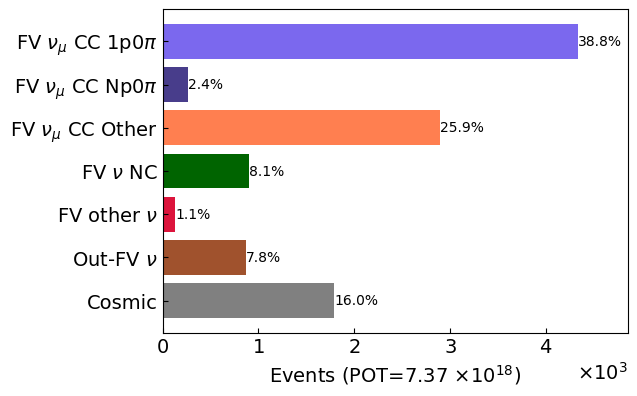

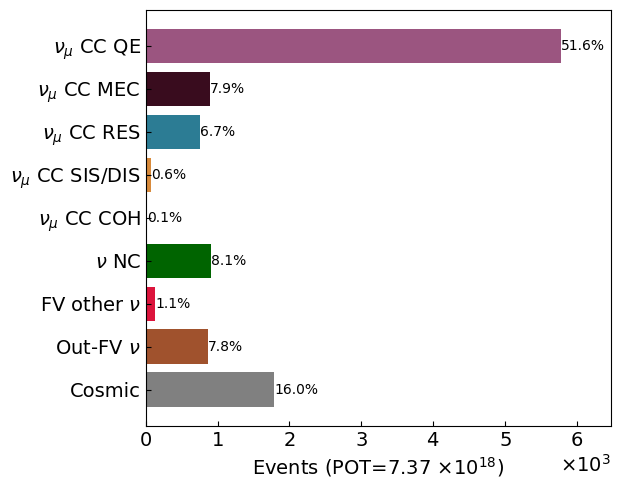

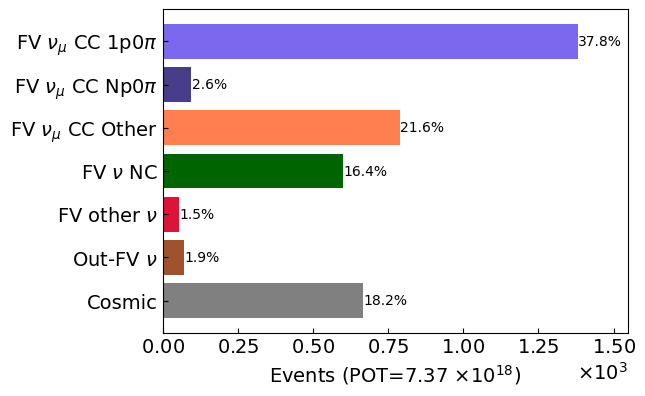

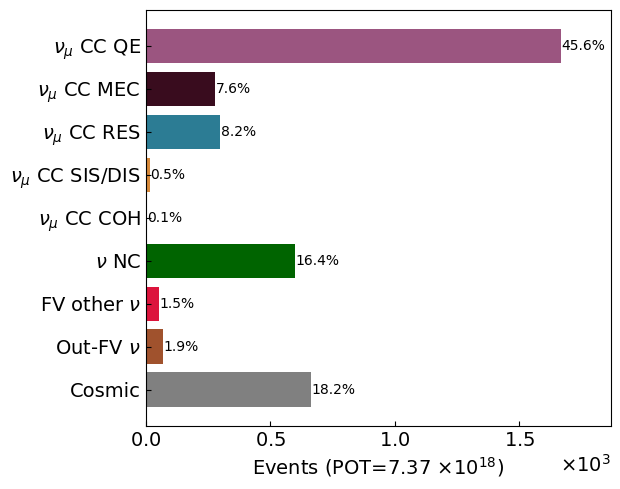

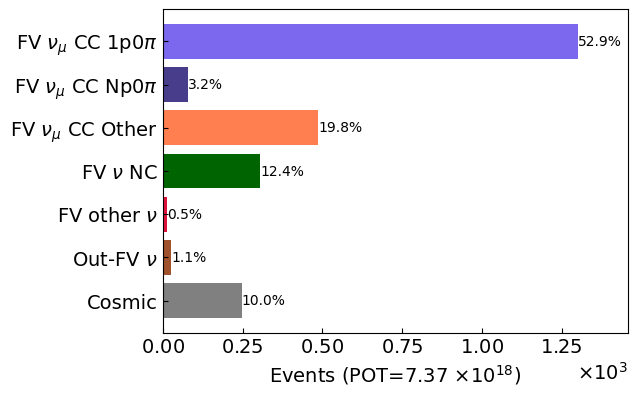

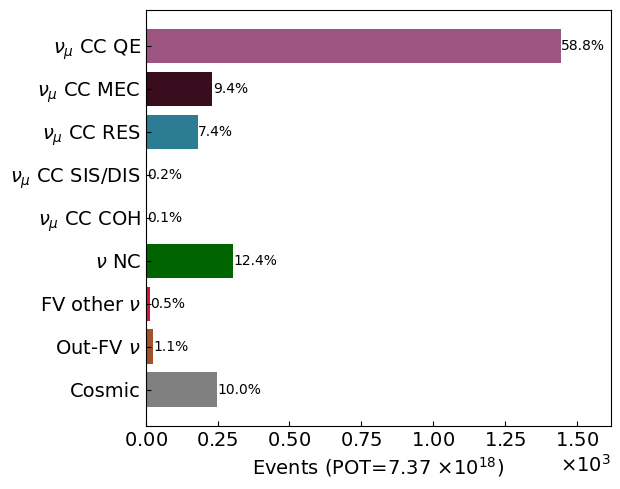

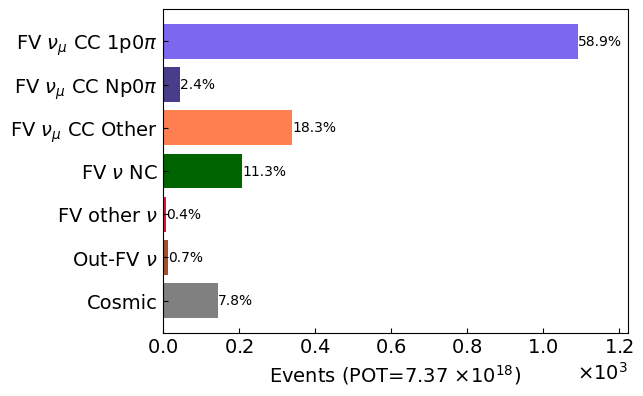

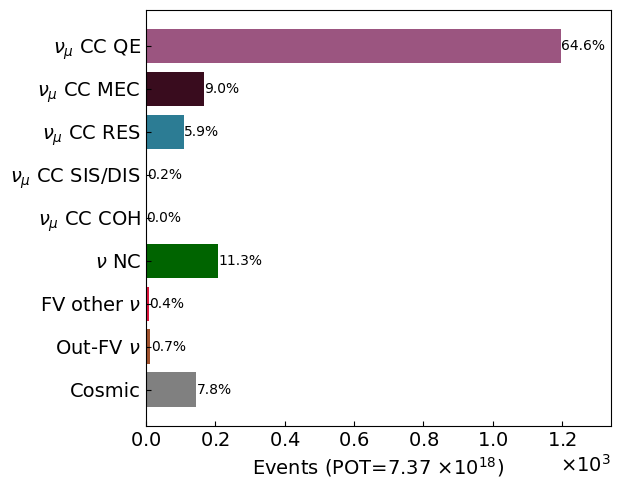

In [ ]:
mc_trk_df_precut = match_trkdf_to_slcdf(mc_trk_df, mc_evt_df_precut)
data_trk_df_precut = match_trkdf_to_slcdf(data_trk_df, data_evt_df_precut)
intime_trk_df_precut = match_trkdf_to_slcdf(intime_trk_df, intime_evt_df_precut)

# TODO: what's pfp.trk.producer = 4294967295? excluding these pfps for now
mc_trk_df_precut = mc_trk_df_precut[mc_trk_df_precut.pfp.trk.producer != 4294967295]
data_trk_df_precut = data_trk_df_precut[data_trk_df_precut.pfp.trk.producer != 4294967295]
intime_trk_df_precut = intime_trk_df_precut[intime_trk_df_precut.pfp.trk.producer != 4294967295]

# number of PFPs
mc_npfps = mc_trk_df_precut.pfp.id.groupby(level=[0,1,2]).count()
data_npfps = data_trk_df_precut.pfp.id.groupby(level=[0,1,2]).count()
intime_npfps = intime_trk_df_precut.pfp.id.groupby(level=[0,1,2]).count()
assert len(mc_evt_df_precut) == len(mc_npfps)
assert len(data_evt_df_precut) == len(data_npfps)
assert len(intime_evt_df_precut) == len(intime_npfps)

# sort by length
# TODO: check length agains start/end position
mc_trk_df_precut = mc_trk_df_precut.sort_values(by=('pfp','trk','len'), ascending=False)
data_trk_df_precut = data_trk_df_precut.sort_values(by=('pfp','trk','len'), ascending=False)
intime_trk_df_precut = intime_trk_df_precut.sort_values(by=('pfp','trk','len'), ascending=False)
# longest track
mc_track1 = mc_trk_df_precut.groupby(level=[0,1,2]).nth(0).reset_index(level=[3])
mc_track2 = mc_trk_df_precut.groupby(level=[0,1,2]).nth(1).reset_index(level=[3])
data_track1 = data_trk_df_precut.groupby(level=[0,1,2]).nth(0).reset_index(level=[3])
data_track2 = data_trk_df_precut.groupby(level=[0,1,2]).nth(1).reset_index(level=[3])
intime_track1 = intime_trk_df_precut.groupby(level=[0,1,2]).nth(0).reset_index(level=[3])
intime_track2 = intime_trk_df_precut.groupby(level=[0,1,2]).nth(1).reset_index(level=[3])


# 2-prong cut
stage_key = "2prong"
mc_mask = (mc_npfps == 2)
mc_evt_df_2prong = mc_evt_df_precut[mc_mask]
data_mask = (data_npfps == 2)
data_evt_df_2prong = data_evt_df_precut[data_mask]
intime_mask = (intime_npfps == 2)
intime_evt_df_2prong = intime_evt_df_precut[intime_mask]

bar_type = "topology"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_2prong, 
                        plot_labels=plot_labels_bar,
                        save_fig=save_fig, save_name=save_name)

bar_type = "genie"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_2prong, 
                        plot_labels=plot_labels_bar,
                        save_fig=save_fig, save_name=save_name)

df_dict[stage_key] = mc_evt_df_2prong
df_dict_data[stage_key] = data_evt_df_2prong
df_dict_intime[stage_key] = intime_evt_df_2prong
perc_dict_topo[stage_key] = ret_topo["perc_list"]
perc_dict_genie[stage_key] = ret_genie["perc_list"]

# both track contained
stage_key = "2prong-contained"
mc_mask = mc_mask & InFV(mc_track1.pfp.trk.end) & InFV(mc_track2.pfp.trk.end)
# mask = mask & InFV(mc_track1.pfp.trk.start) & InFV(mc_track2.pfp.trk.start)
mc_evt_df_2prong = mc_evt_df_precut[mc_mask]
data_mask = data_mask & InFV(data_track1.pfp.trk.end) & InFV(data_track2.pfp.trk.end)
data_evt_df_2prong = data_evt_df_precut[data_mask]
intime_mask = intime_mask & InFV(intime_track1.pfp.trk.end) & InFV(intime_track2.pfp.trk.end)
intime_evt_df_2prong = intime_evt_df_precut[intime_mask]

bar_type = "topology"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_2prong, 
                        plot_labels=plot_labels_bar,
                        save_fig=save_fig, save_name=save_name)

bar_type = "genie"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_2prong, 
                        plot_labels=plot_labels_bar,
                        save_fig=save_fig, save_name=save_name)

df_dict[stage_key] = mc_evt_df_2prong
df_dict_data[stage_key] = data_evt_df_2prong
df_dict_intime[stage_key] = intime_evt_df_2prong
perc_dict_topo[stage_key] = ret_topo["perc_list"]
perc_dict_genie[stage_key] = ret_genie["perc_list"]

# both track have trackscore > 0.5
stage_key = "2prong-trackscore"
trackscore_th = 0.5
mc_mask = mc_mask & (mc_track1.pfp.trackScore > trackscore_th) & (mc_track2.pfp.trackScore > trackscore_th)
mc_evt_df_2prong = mc_evt_df_precut[mc_mask]
data_mask = data_mask & (data_track1.pfp.trackScore > trackscore_th) & (data_track2.pfp.trackScore > trackscore_th)
data_evt_df_2prong = data_evt_df_precut[data_mask]
intime_mask = intime_mask & (intime_track1.pfp.trackScore > trackscore_th) & (intime_track2.pfp.trackScore > trackscore_th)
intime_evt_df_2prong = intime_evt_df_precut[intime_mask]

bar_type = "topology"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_2prong, 
                        plot_labels=plot_labels_bar,
                        save_fig=save_fig, save_name=save_name)

bar_type = "genie"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_2prong, 
                        plot_labels=plot_labels_bar,
                        save_fig=save_fig, save_name=save_name)

df_dict[stage_key] = mc_evt_df_2prong
df_dict_data[stage_key] = data_evt_df_2prong
df_dict_intime[stage_key] = intime_evt_df_2prong
perc_dict_topo[stage_key] = ret_topo["perc_list"]
perc_dict_genie[stage_key] = ret_genie["perc_list"]


# both start (position - vertex) < 1 cm
stage_key = "2prong-start_vertex_dist"
dist_th = 1.2
mc_mask = mc_mask & (mag3d(mc_track1.pfp.trk.start, mc_evt_df_precut.slc.vertex) < dist_th) & (mag3d(mc_track2.pfp.trk.start, mc_evt_df_precut.slc.vertex) < dist_th)
mc_evt_df_2prong = mc_evt_df_precut[mc_mask]
data_mask = data_mask & (mag3d(data_track1.pfp.trk.start, data_evt_df_precut.slc.vertex) < dist_th) & (mag3d(data_track2.pfp.trk.start, data_evt_df_precut.slc.vertex) < dist_th)
data_evt_df_2prong = data_evt_df_precut[data_mask]
intime_mask = intime_mask & (mag3d(intime_track1.pfp.trk.start, intime_evt_df_precut.slc.vertex) < dist_th) & (mag3d(intime_track2.pfp.trk.start, intime_evt_df_precut.slc.vertex) < dist_th)
intime_evt_df_2prong = intime_evt_df_precut[intime_mask]

bar_type = "topology"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_2prong,
                        plot_labels=plot_labels_bar,
                        save_fig=save_fig, save_name=save_name)

bar_type = "genie"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_2prong, 
                        plot_labels=plot_labels_bar,
                        save_fig=save_fig, save_name=save_name)

df_dict[stage_key] = mc_evt_df_2prong
df_dict_data[stage_key] = data_evt_df_2prong
df_dict_intime[stage_key] = intime_evt_df_2prong
perc_dict_topo[stage_key] = ret_topo["perc_list"]
perc_dict_genie[stage_key] = ret_genie["perc_list"]

# longer track > 50 cm
# mask = mask & (mc_track1.pfp.trk.len > 50)
# mc_evt_df_2prong = mc_evt_df_precut[mask]
# bar_plot(type=bar_type, evtdf=mc_evt_df_2prong)

# tracks that belong to the slices that paseed the above cuts
# mc_track dfs have the same index levels as slc dfs
mc_track1 = mc_track1.loc[mc_evt_df_2prong.index]
mc_track2 = mc_track2.loc[mc_evt_df_2prong.index]
data_track1 = data_track1.loc[data_evt_df_2prong.index]
data_track2 = data_track2.loc[data_evt_df_2prong.index]
intime_track1 = intime_track1.loc[intime_evt_df_2prong.index]
intime_track2 = intime_track2.loc[intime_evt_df_2prong.index]


## Data vs. MC Comparison

(array([    0.,  8463., 22835., 16949.,  9709.,  4656.,  2106.,   838.,
          544.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

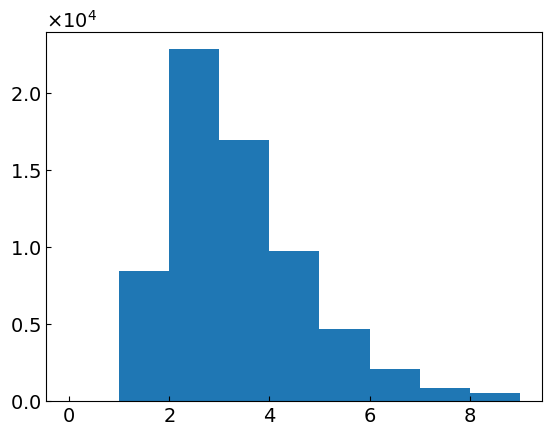

In [ ]:
var_mc = mc_npfps
var_data = data_npfps
plt.hist(var_mc, bins=np.arange(0, 10, 1))
plt.show()

## Efficiency

# PID
- cut on track length & chi2 scores
- (MCS fwd P - MCS bwd P)
- quality cut on (range P - MCS P)
- TODO: number of daughter particles?

In [ ]:
# compbine longer & shorter tracks into one df
mc_trk_df_2prong = pd.concat([mc_track1.reset_index().set_index(mc_trk_df.index.names),
                              mc_track2.reset_index().set_index(mc_trk_df.index.names)])
data_trk_df_2prong = pd.concat([data_track1.reset_index().set_index(data_trk_df.index.names),
                              data_track2.reset_index().set_index(data_trk_df.index.names)])
intime_trk_df_2prong = pd.concat([intime_track1.reset_index().set_index(intime_trk_df.index.names),
                              intime_track2.reset_index().set_index(intime_trk_df.index.names)])


## Selection

In [ ]:
def avg_chi2(df, var_name):
    # planes = ['I0', 'I1', 'I2']
    planes = ['I2']
    chi2_vals = []
    for plane in planes:
        chi2 = df['pfp']['trk']['chi2pid'][plane][var_name]
        chi2_vals.append(chi2)
    chi2_df = pd.concat(chi2_vals, axis=1)
    # fill 0 with nan
    chi2_df = chi2_df.replace(0, np.nan)
    avg = chi2_df.mean(axis=1, skipna=True)
    return avg

In [ ]:
# TODO: average score over planes
# ---- find muon candidate from all tracks
# purity scan
mc_chimu_avg = avg_chi2(mc_trk_df_2prong, "chi2_muon")
mc_chip_avg = avg_chi2(mc_trk_df_2prong, "chi2_proton")
data_chimu_avg = avg_chi2(data_trk_df_2prong, "chi2_muon")
data_chip_avg = avg_chi2(data_trk_df_2prong, "chi2_proton")
intime_chimu_avg = avg_chi2(intime_trk_df_2prong, "chi2_muon")
intime_chip_avg = avg_chi2(intime_trk_df_2prong, "chi2_proton")

# --- optimized cut
mu_chi2mu_th = 30
mu_chi2p_th = 100
mu_len_th = 50

# mu_cut = (mc_trk_df_2prong.pfp.trk.chi2pid.I2.chi2_muon > 0) & (mc_trk_df_2prong.pfp.trk.chi2pid.I2.chi2_muon < mu_chi2mu_th) & (mc_trk_df_2prong.pfp.trk.chi2pid.I2.chi2_proton > mu_chi2p_th)
mc_mu_cut = (mc_chimu_avg > 0) & (mc_chimu_avg < mu_chi2mu_th) & (mc_chip_avg > mu_chi2p_th)
mc_mu_cut = mc_mu_cut & (mc_trk_df_2prong.pfp.trk.len > 50)
mc_mu_candidates = mc_trk_df_2prong[mc_mu_cut]
mc_mu_candidates_prequal = mc_mu_candidates
data_mu_cut = (data_chimu_avg > 0) & (data_chimu_avg < mu_chi2mu_th) & (data_chip_avg > mu_chi2p_th)
data_mu_cut = data_mu_cut & (data_trk_df_2prong.pfp.trk.len > 50)
data_mu_candidates = data_trk_df_2prong[data_mu_cut]
data_mu_candidates_prequal = data_mu_candidates
intime_mu_cut = (intime_chimu_avg > 0) & (intime_chimu_avg < mu_chi2mu_th) & (intime_chip_avg > mu_chi2p_th)
intime_mu_cut = intime_mu_cut & (intime_trk_df_2prong.pfp.trk.len > 50)
intime_mu_candidates = intime_trk_df_2prong[intime_mu_cut]
intime_mu_candidates_prequal = intime_mu_candidates

# more muon-like than pion-like
# mu_cut = mu_cut & (mc_trk_df_2prong.pfp.trk.chi2pid.I2.chi2_muon < mc_trk_df_2prong.pfp.trk.chi2pid.I2.chi2_pion * 0.9)

# muon quality cut
mc_mu_cut = mc_mu_cut & (np.abs((mc_trk_df_2prong.pfp.trk.rangeP.p_muon - mc_trk_df_2prong.pfp.trk.mcsP.fwdP_muon) / mc_trk_df_2prong.pfp.trk.rangeP.p_muon) < 0.5)
mc_mu_candidates = mc_trk_df_2prong[mc_mu_cut]
data_mu_cut = data_mu_cut & (np.abs((data_trk_df_2prong.pfp.trk.rangeP.p_muon - data_trk_df_2prong.pfp.trk.mcsP.fwdP_muon) / data_trk_df_2prong.pfp.trk.rangeP.p_muon) < 0.5)
data_mu_candidates = data_trk_df_2prong[data_mu_cut]
intime_mu_cut = intime_mu_cut & (np.abs((intime_trk_df_2prong.pfp.trk.rangeP.p_muon - intime_trk_df_2prong.pfp.trk.mcsP.fwdP_muon) / intime_trk_df_2prong.pfp.trk.rangeP.p_muon) < 0.5)
intime_mu_candidates = intime_trk_df_2prong[intime_mu_cut]

# if multiple mu candidates in a slice, choose the longer one
mc_mu_candidates = mc_mu_candidates.sort_values(by=('pfp', 'trk', 'len'), ascending=False)
mc_mu_candidate = mc_mu_candidates.groupby(level=[0,1,2]).nth(0)
data_mu_candidates = data_mu_candidates.sort_values(by=('pfp', 'trk', 'len'), ascending=False)
data_mu_candidate = data_mu_candidates.groupby(level=[0,1,2]).nth(0)
intime_mu_candidates = intime_mu_candidates.sort_values(by=('pfp', 'trk', 'len'), ascending=False)
intime_mu_candidate = intime_mu_candidates.groupby(level=[0,1,2]).nth(0)

mc_mu_eff = len(mc_mu_candidates[mc_mu_candidates.pfp.trk.truth.p.pdg == 13])/len(mc_trk_df_2prong[mc_trk_df_2prong.pfp.trk.truth.p.pdg == 13])
mc_mu_purity = len(mc_mu_candidate[mc_mu_candidate.pfp.trk.truth.p.pdg == 13])/len(mc_mu_candidate)
print("chimu: {}, chip: {}, muon efficiency: {}, purity: {}".format(mu_chi2mu_th, mu_chi2p_th, mc_mu_eff, mc_mu_purity))

chimu: 30, chip: 100, muon efficiency: 0.7919696490673411, purity: 0.9433320740460899


In [ ]:
mc_trk_idx = mc_trk_df_2prong.index.difference(mc_mu_candidate.index)
mc_not_mu_candidate = mc_trk_df_2prong.loc[mc_trk_idx]
mc_chimu_avg = avg_chi2(mc_not_mu_candidate, "chi2_muon")
mc_chip_avg = avg_chi2(mc_not_mu_candidate, "chi2_proton")
data_trk_idx = data_trk_df_2prong.index.difference(data_mu_candidate.index)
data_not_mu_candidate = data_trk_df_2prong.loc[data_trk_idx]
data_chimu_avg = avg_chi2(data_not_mu_candidate, "chi2_muon")
data_chip_avg = avg_chi2(data_not_mu_candidate, "chi2_proton")
intime_trk_idx = intime_trk_df_2prong.index.difference(intime_mu_candidate.index)
intime_not_mu_candidate = intime_trk_df_2prong.loc[intime_trk_idx]
intime_chimu_avg = avg_chi2(intime_not_mu_candidate, "chi2_muon")
intime_chip_avg = avg_chi2(intime_not_mu_candidate, "chi2_proton")

# ---- in leftovers, find proton candidates
p_chi2p_th = 90

# p_cut = (not_mu_candidate.pfp.trk.chi2pid.I2.chi2_proton > 0) & (not_mu_candidate.pfp.trk.chi2pid.I2.chi2_proton < p_chi2p_th)
mc_p_cut = (mc_chip_avg > 0) & (mc_chip_avg < p_chi2p_th)
mc_p_candidates = mc_not_mu_candidate[mc_p_cut]
data_p_cut = (data_chip_avg > 0) & (data_chip_avg < p_chi2p_th)
data_p_candidates = data_not_mu_candidate[data_p_cut]
intime_p_cut = (intime_chip_avg > 0) & (intime_chip_avg < p_chi2p_th)
intime_p_candidates = intime_not_mu_candidate[intime_p_cut]

print("proton efficiency", len(mc_p_candidates[mc_p_candidates.pfp.trk.truth.p.pdg == 2212])/len(mc_not_mu_candidate[mc_not_mu_candidate.pfp.trk.truth.p.pdg == 2212]))
print("proton purity", len(mc_p_candidates[mc_p_candidates.pfp.trk.truth.p.pdg == 2212])/len(mc_p_candidates))

proton efficiency 0.8674859738177932
proton purity 0.9724468403713686


mc_mu_idx 2628
mc_p_idx 2926
mc_mu_p_idx 2003
data_mu_idx 1527
data_p_idx 1561
data_mu_p_idx 1100
intime_mu_idx 47
intime_p_idx 11
intime_mu_p_idx 3


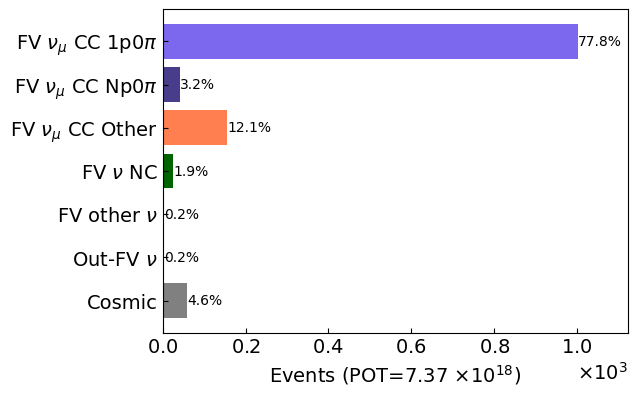

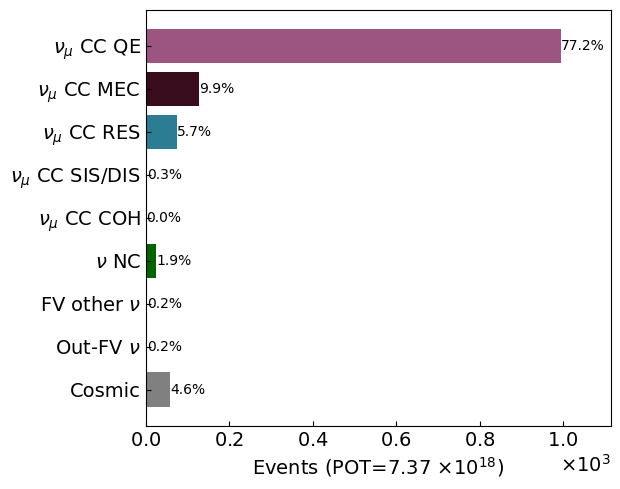

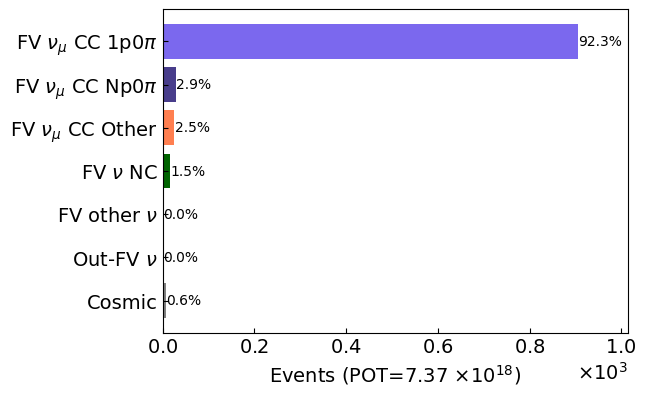

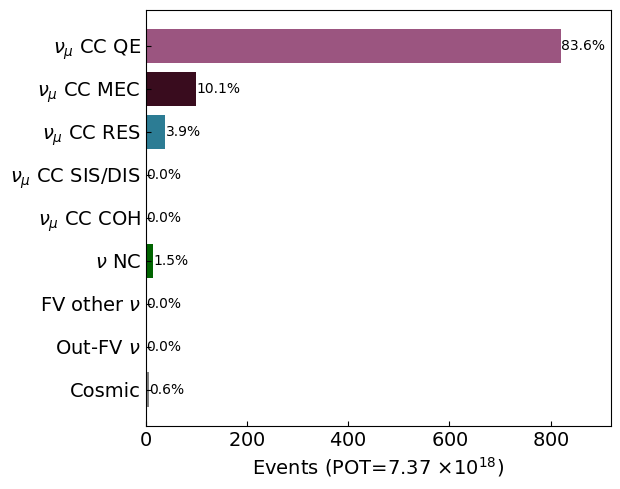

In [ ]:
# ---- limit to the target kinematic range 
MASS_MUON = 0.1056583745
mu_low_th = 0.22
mu_hi_th = 1

mc_mu_kin_cut = (mc_mu_candidate.pfp.trk.rangeP.p_muon > mu_low_th)
mc_mu_kin_cut = mc_mu_kin_cut & (mc_mu_candidate.pfp.trk.rangeP.p_muon < mu_hi_th)
mc_mu_candidate = mc_mu_candidate[mc_mu_kin_cut]
data_mu_kin_cut = (data_mu_candidate.pfp.trk.rangeP.p_muon > mu_low_th)
data_mu_kin_cut = data_mu_kin_cut & (data_mu_candidate.pfp.trk.rangeP.p_muon < mu_hi_th)
data_mu_candidate = data_mu_candidate[data_mu_kin_cut]
intime_mu_kin_cut = (intime_mu_candidate.pfp.trk.rangeP.p_muon > mu_low_th)
intime_mu_kin_cut = intime_mu_kin_cut & (intime_mu_candidate.pfp.trk.rangeP.p_muon < mu_hi_th)
intime_mu_candidate = intime_mu_candidate[intime_mu_kin_cut]

MASS_PROTON = 0.938272081
p_low_th = 0.3
p_hi_th = 1

mc_p_kin_cut = (mc_p_candidates.pfp.trk.rangeP.p_proton > p_low_th)
mc_p_kin_cut = mc_p_kin_cut & (mc_p_candidates.pfp.trk.rangeP.p_proton < p_hi_th)
mc_p_candidates = mc_p_candidates[mc_p_kin_cut]
data_p_kin_cut = (data_p_candidates.pfp.trk.rangeP.p_proton > p_low_th)
data_p_kin_cut = data_p_kin_cut & (data_p_candidates.pfp.trk.rangeP.p_proton < p_hi_th)
data_p_candidates = data_p_candidates[data_p_kin_cut]
intime_p_kin_cut = (intime_p_candidates.pfp.trk.rangeP.p_proton > p_low_th)
intime_p_kin_cut = intime_p_kin_cut & (intime_p_candidates.pfp.trk.rangeP.p_proton < p_hi_th)
intime_p_candidates = intime_p_candidates[intime_p_kin_cut]

# select mu-X slice
stage_key = "2prong-muX"
mc_mu_idx = mc_mu_candidate.reset_index(level=[3]).index.unique()
mc_evt_df_muX = mc_evt_df_2prong.loc[mc_mu_idx]
data_mu_idx = data_mu_candidate.reset_index(level=[3]).index.unique()
data_evt_df_muX = data_evt_df_2prong.loc[data_mu_idx]
intime_mu_idx = intime_mu_candidate.reset_index(level=[3]).index.unique()
intime_evt_df_muX = intime_evt_df_2prong.loc[intime_mu_idx]

bar_type = "topology"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_muX,
                     plot_labels=plot_labels_bar,
                     save_fig=save_fig, save_name=save_name)

bar_type = "genie"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_muX, 
                      plot_labels=plot_labels_bar,
                      save_fig=save_fig, save_name=save_name)

df_dict[stage_key] = mc_evt_df_muX
df_dict_data[stage_key] = data_evt_df_muX
df_dict_intime[stage_key] = intime_evt_df_muX
perc_dict_topo[stage_key] = ret_topo["perc_list"]
perc_dict_genie[stage_key] = ret_genie["perc_list"]

# select mu-p slice
stage_key = "2prong-mup"
mc_p_idx = mc_p_candidates.reset_index(level=[3]).index.unique()
mc_mu_p_idx = mc_mu_idx.intersection(mc_p_idx)
print("mc_mu_idx", len(mc_mu_idx))
print("mc_p_idx", len(mc_p_idx))
print("mc_mu_p_idx", len(mc_mu_p_idx))
data_p_idx = data_p_candidates.reset_index(level=[3]).index.unique()
data_mu_p_idx = data_mu_idx.intersection(data_p_idx)
print("data_mu_idx", len(data_mu_idx))
print("data_p_idx", len(data_p_idx))
print("data_mu_p_idx", len(data_mu_p_idx))
intime_p_idx = intime_p_candidates.reset_index(level=[3]).index.unique()
intime_mu_p_idx = intime_mu_idx.intersection(intime_p_idx)
print("intime_mu_idx", len(intime_mu_idx))
print("intime_p_idx", len(intime_p_idx))
print("intime_mu_p_idx", len(intime_mu_p_idx))

mc_evt_df_mup = mc_evt_df_2prong.loc[mc_mu_p_idx]
data_evt_df_mup = data_evt_df_2prong.loc[data_mu_p_idx]
intime_evt_df_mup = intime_evt_df_2prong.loc[intime_mu_p_idx]
bar_type = "topology"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_mup,
                     plot_labels=plot_labels_bar,
                     save_fig=save_fig, save_name=save_name)

bar_type = "genie"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_mup, 
                      plot_labels=plot_labels_bar,
                      save_fig=save_fig, save_name=save_name)

df_dict[stage_key] = mc_evt_df_mup
df_dict_data[stage_key] = data_evt_df_mup
df_dict_intime[stage_key] = intime_evt_df_mup
perc_dict_topo[stage_key] = ret_topo["perc_list"]
perc_dict_genie[stage_key] = ret_genie["perc_list"]

# match tracks to slices
mc_mu_df = match_trkdf_to_slcdf(mc_mu_candidate, mc_evt_df_mup)
mc_p_df = match_trkdf_to_slcdf(mc_p_candidates, mc_evt_df_mup)
data_mu_df = match_trkdf_to_slcdf(data_mu_candidate, data_evt_df_mup)
data_p_df = match_trkdf_to_slcdf(data_p_candidates, data_evt_df_mup)
intime_mu_df = match_trkdf_to_slcdf(intime_mu_candidate, intime_evt_df_mup)
intime_p_df = match_trkdf_to_slcdf(intime_p_candidates, intime_evt_df_mup)


## Data vs. MC Comparison

In [ ]:
# TODO: are there any cases where the proton is longer than the muon?

longer_muon_1mu1p = (mc_track1.pfp.trk.truth.p.pdg == 13) & (mc_track2.pfp.trk.truth.p.pdg == 2212)
longer_proton_1mu1p = (mc_track1.pfp.trk.truth.p.pdg == 2212) & (mc_track2.pfp.trk.truth.p.pdg == 13)

print("1mu1p, longer muon", longer_muon_1mu1p.sum()/len(longer_muon_1mu1p))
print("1mu1p, longer proton", longer_proton_1mu1p.sum()/len(longer_muon_1mu1p))

longer_muon_1mu1mu = (mc_track1.pfp.trk.truth.p.pdg == 13) & (mc_track2.pfp.trk.truth.p.pdg == 13)
print("1mu1mu, longer muon", longer_muon_1mu1mu.sum()/len(longer_muon_1mu1mu))

piplus_proton = (mc_track1.pfp.trk.truth.p.pdg == 211) & (mc_track2.pfp.trk.truth.p.pdg == 2212)
piminus_proton = (mc_track1.pfp.trk.truth.p.pdg == -211) & (mc_track2.pfp.trk.truth.p.pdg == 2212)
print("piplus_proton", piplus_proton.sum()/len(piplus_proton))
print("piminus_proton", piminus_proton.sum()/len(piminus_proton))

mu_piplus = (mc_track1.pfp.trk.truth.p.pdg == 13) & (mc_track2.pfp.trk.truth.p.pdg == 211)
mu_piminus = (mc_track1.pfp.trk.truth.p.pdg == 13) & (mc_track2.pfp.trk.truth.p.pdg == -211)
print("mu_piplus", mu_piplus.sum()/len(mu_piplus))
print("mu_piminus", mu_piminus.sum()/len(mu_piminus))

print("-----------------")
print("longer track")
print(mc_track1.pfp.trk.truth.p.pdg.value_counts())
print("shorter track")
print(mc_track2.pfp.trk.truth.p.pdg.value_counts())

1mu1p, longer muon 0.7100185038329369
1mu1p, longer proton 0.03647898493259318
1mu1mu, longer muon 0.02590536611155168
piplus_proton 0.0050224689399947136
piminus_proton 0.022997620935765267
mu_piplus 0.010573618821041502
mu_piminus 0.0002643404705260375
-----------------
longer track
pdg
 13            2900
 2212           589
-13             107
-211            101
 211             68
 22               9
-11               5
 1000010020       2
 11               2
Name: count, dtype: int64
shorter track
pdg
 2212          3165
 13             263
-11             103
-211             91
 11              73
 211             56
-13              17
 1000010020       8
 22               7
Name: count, dtype: int64


# Results

In [ ]:
mc_mu_df = mc_mu_df.reset_index(level=[3])
mc_p_df = mc_p_df.reset_index(level=[3])

data_mu_df = data_mu_df.reset_index(level=[3])
data_p_df = data_p_df.reset_index(level=[3])

intime_mu_df = intime_mu_df.reset_index(level=[3])
intime_p_df = intime_p_df.reset_index(level=[3])


In [ ]:
eps = 1e-8

## data vs. MC of measurement variables

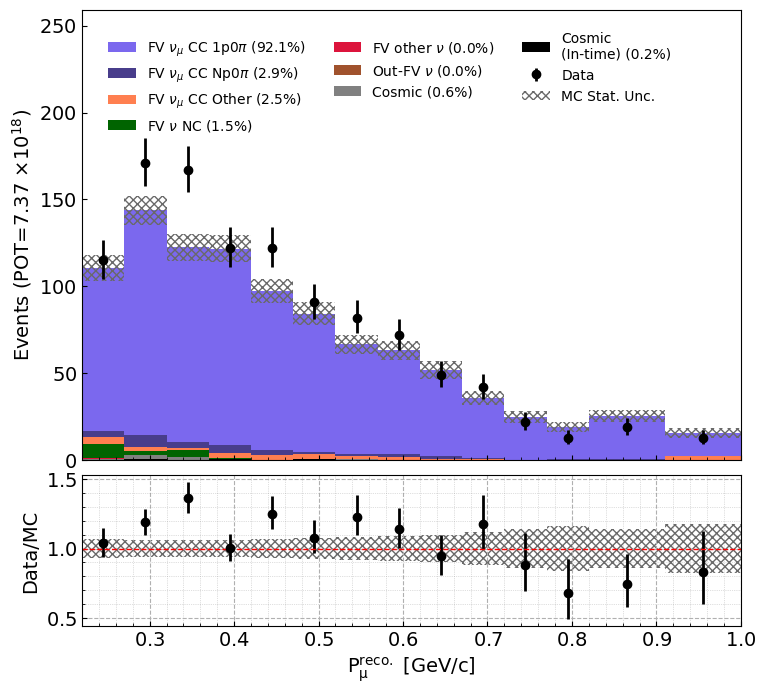

numu NC 31


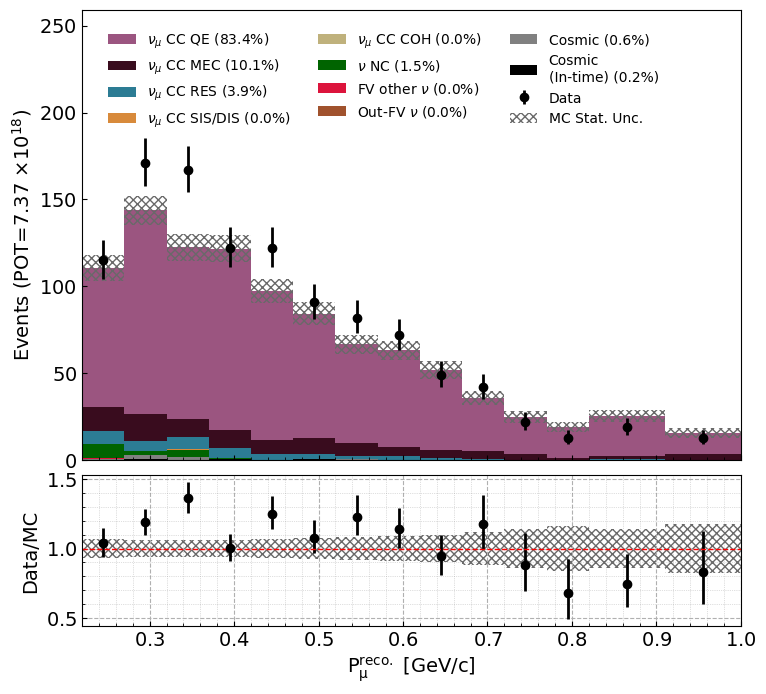

In [ ]:
# muon momentum 
var_config = VariableConfig.muon_momentum()
evtdf = mc_evt_df_mup
vardf = mc_mu_df.pfp.trk.rangeP.p_muon
vardf_data = data_mu_df.pfp.trk.rangeP.p_muon
vardf_intime = intime_mu_df.pfp.trk.rangeP.p_muon
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)

# plot
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

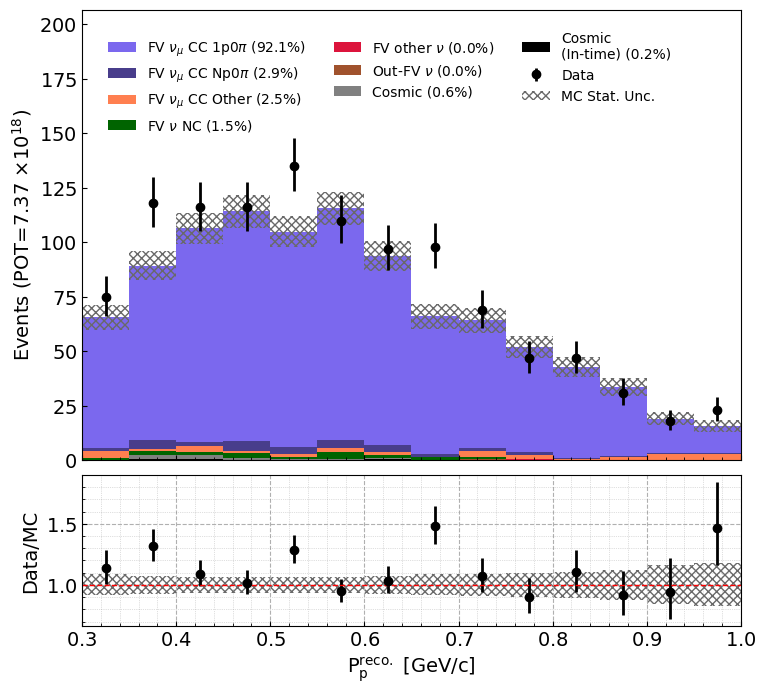

numu NC 31


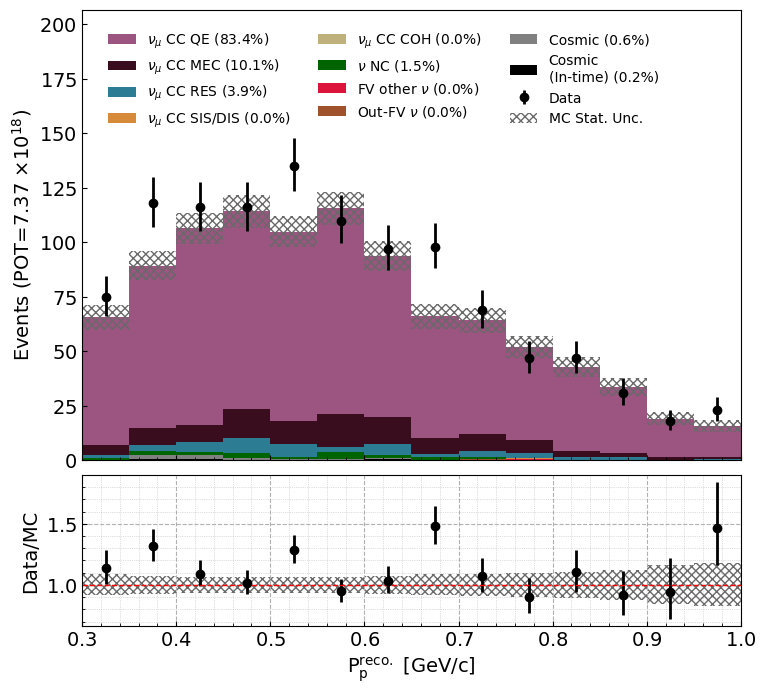

In [ ]:
# proton momentum 
var_config = VariableConfig.proton_momentum()
evtdf = mc_evt_df_mup
vardf = mc_p_df.pfp.trk.rangeP.p_proton
vardf_data = data_p_df.pfp.trk.rangeP.p_proton
vardf_intime = intime_p_df.pfp.trk.rangeP.p_proton
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

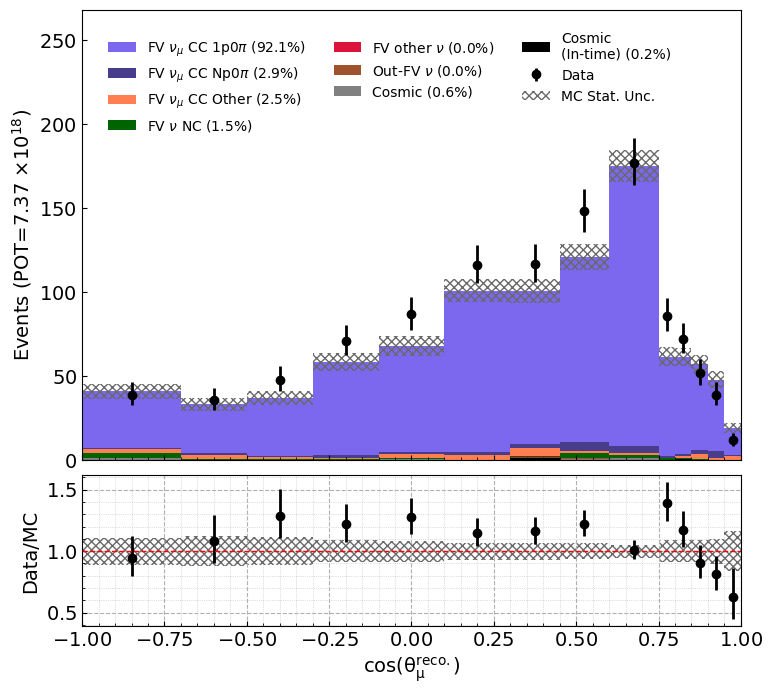

numu NC 31


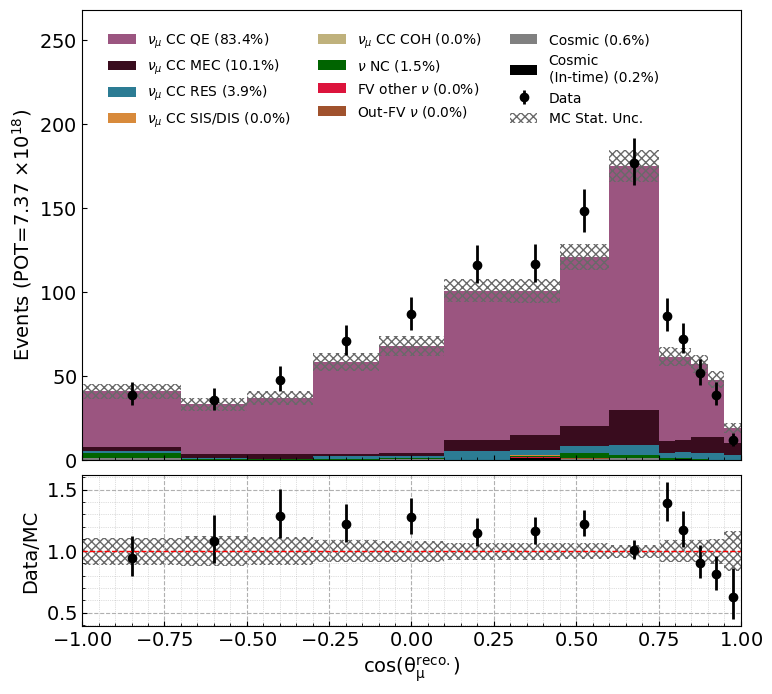

In [ ]:
# Muon z-direction
var_config = VariableConfig.muon_direction()
evtdf = mc_evt_df_mup
vardf = mc_mu_df.pfp.trk.dir.z
vardf_data = data_mu_df.pfp.trk.dir.z
vardf_intime = intime_mu_df.pfp.trk.dir.z
bins = var_config.bins
vardf = np.clip(vardf, var_config.bins[0], var_config.bins[-1] - eps)
vardf_data = np.clip(vardf_data, var_config.bins[0], var_config.bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, var_config.bins[0], var_config.bins[-1] - eps)
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

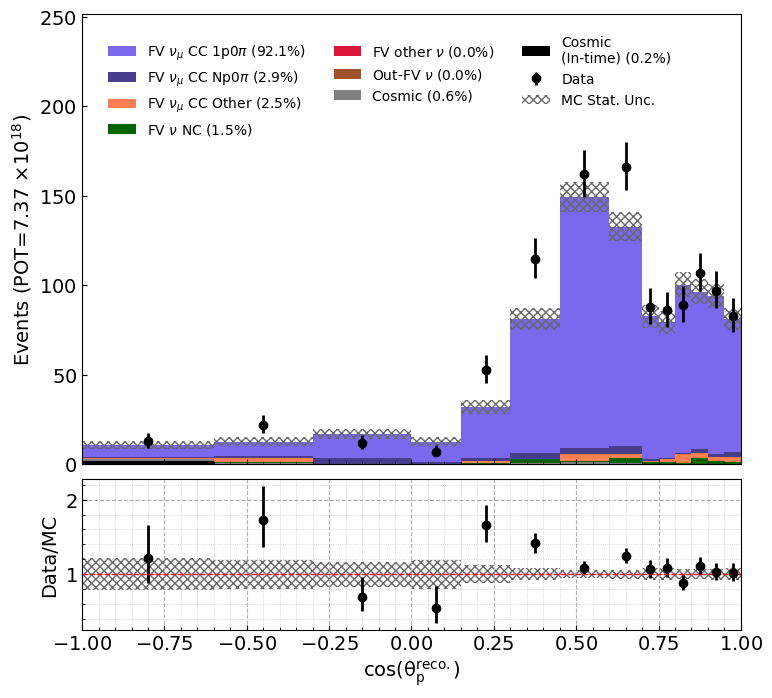

numu NC 31


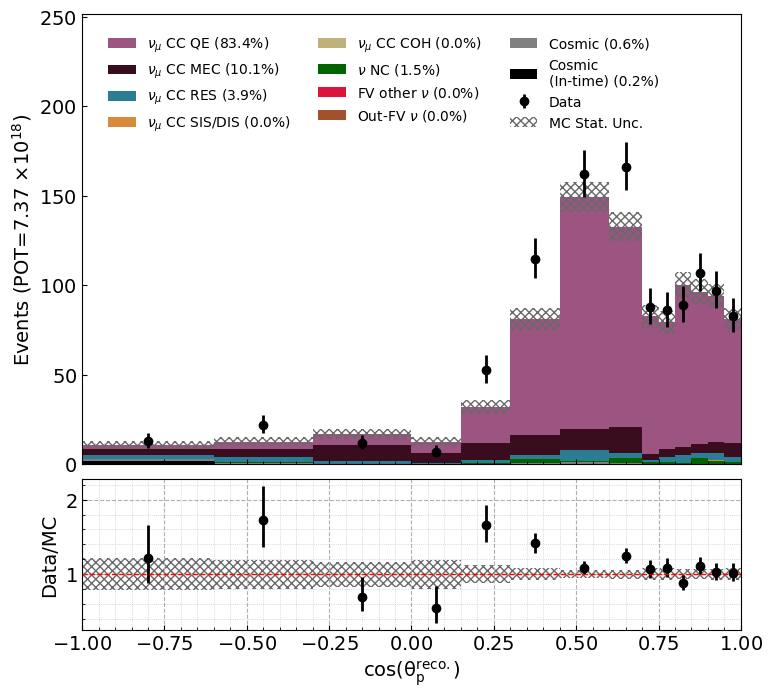

In [ ]:
# proton z-direction
var_config = VariableConfig.proton_direction()
evtdf = mc_evt_df_mup
vardf = mc_p_df.pfp.trk.dir.z
vardf_data = data_p_df.pfp.trk.dir.z
vardf_intime = intime_p_df.pfp.trk.dir.z
bins = var_config.bins
vardf = np.clip(vardf, var_config.bins[0], var_config.bins[-1] - eps)
vardf_data = np.clip(vardf_data, var_config.bins[0], var_config.bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, var_config.bins[0], var_config.bins[-1] - eps)
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

In [ ]:
P_mu_col = pad_column_name(("rangeP", "p_muon"), mc_mu_df.pfp.trk)
P_p_col = pad_column_name(("rangeP", "p_proton"), mc_p_df.pfp.trk)

mc_ret_tki = get_cc1p0pi_tki(mc_mu_df.pfp.trk, mc_p_df.pfp.trk, P_mu_col, P_p_col)
data_ret_tki = get_cc1p0pi_tki(data_mu_df.pfp.trk, data_p_df.pfp.trk, P_mu_col, P_p_col)
intime_ret_tki = get_cc1p0pi_tki(intime_mu_df.pfp.trk, intime_p_df.pfp.trk, P_mu_col, P_p_col)

In [ ]:
mc_ret_tki.keys()

dict_keys(['del_alpha', 'del_phi', 'del_Tp', 'del_Tp_x', 'del_Tp_y', 'del_p'])

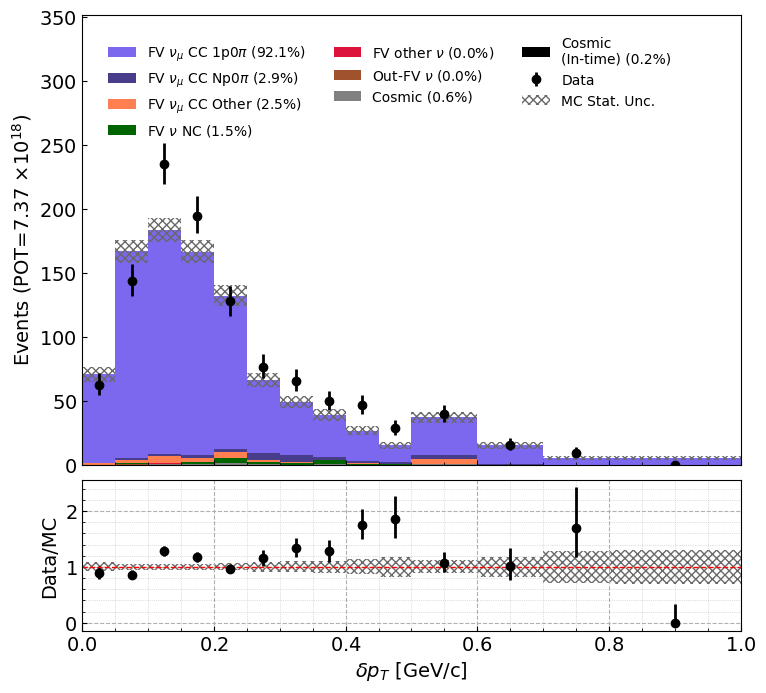

numu NC 31


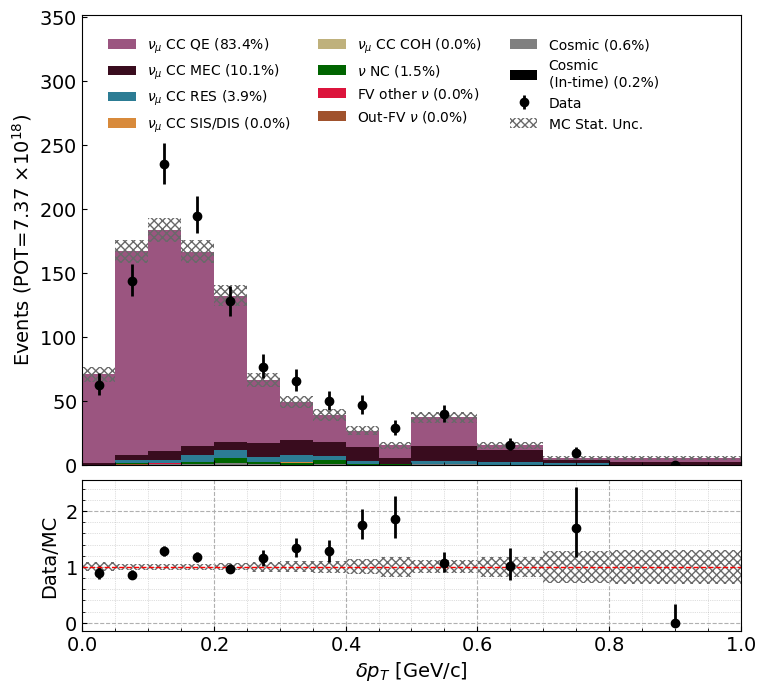

In [ ]:
evtdf = mc_evt_df_mup
tki_name = "del_Tp"
var_config = VariableConfig.tki_del_Tp()
vardf = mc_ret_tki[tki_name]
vardf_data = data_ret_tki[tki_name]
vardf_intime = intime_ret_tki[tki_name]
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta p_T$ [GeV/c]",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

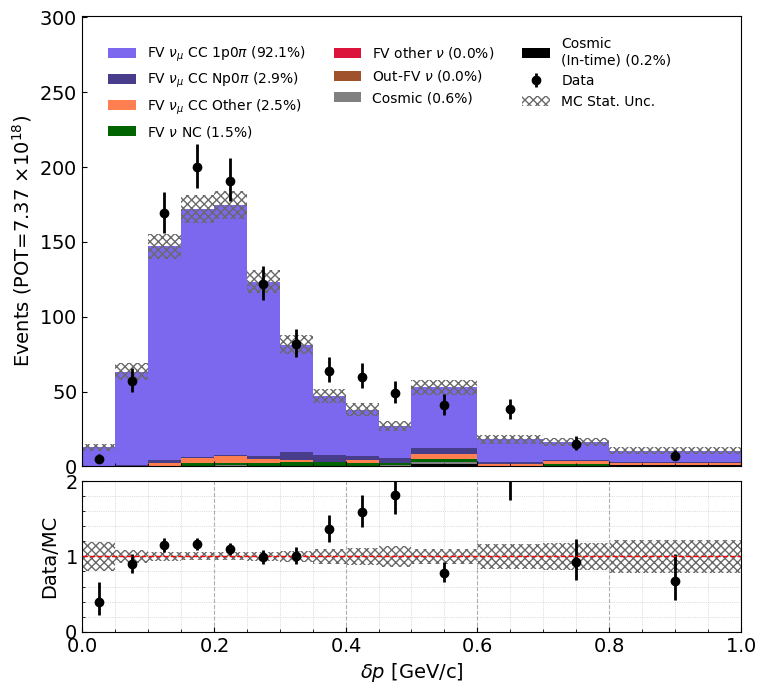

numu NC 31


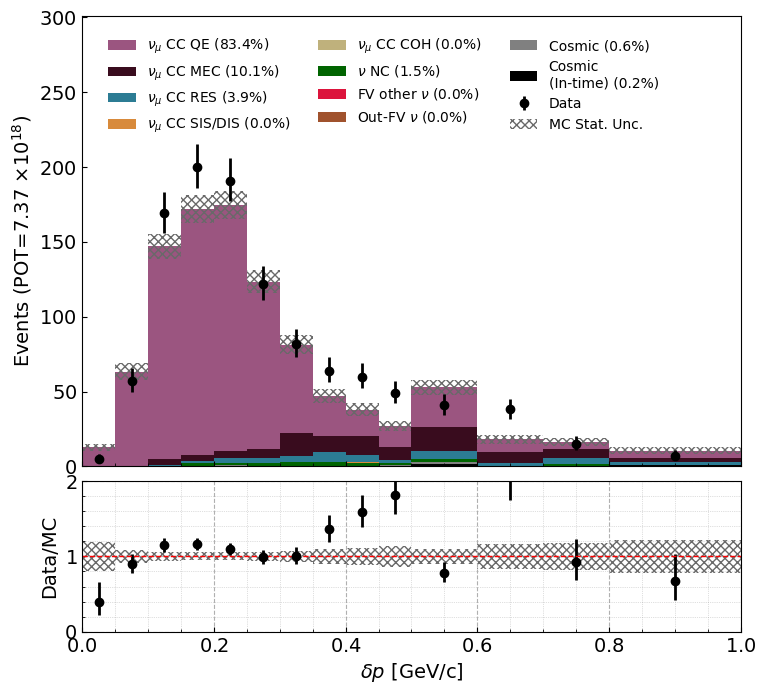

In [ ]:
# Muon z-direction
evtdf = mc_evt_df_mup
tki_name = "del_p"
var_config = VariableConfig.tki_del_p()
vardf = mc_ret_tki[tki_name]
vardf_data = data_ret_tki[tki_name]
vardf_intime = intime_ret_tki[tki_name]
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta p$ [GeV/c]",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-tki-del_p_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-tki-del_p_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

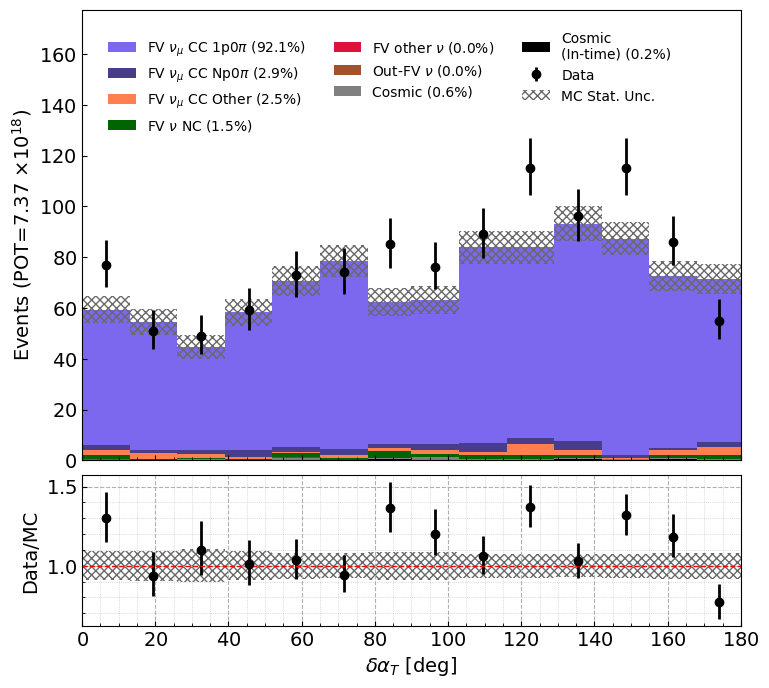

numu NC 31


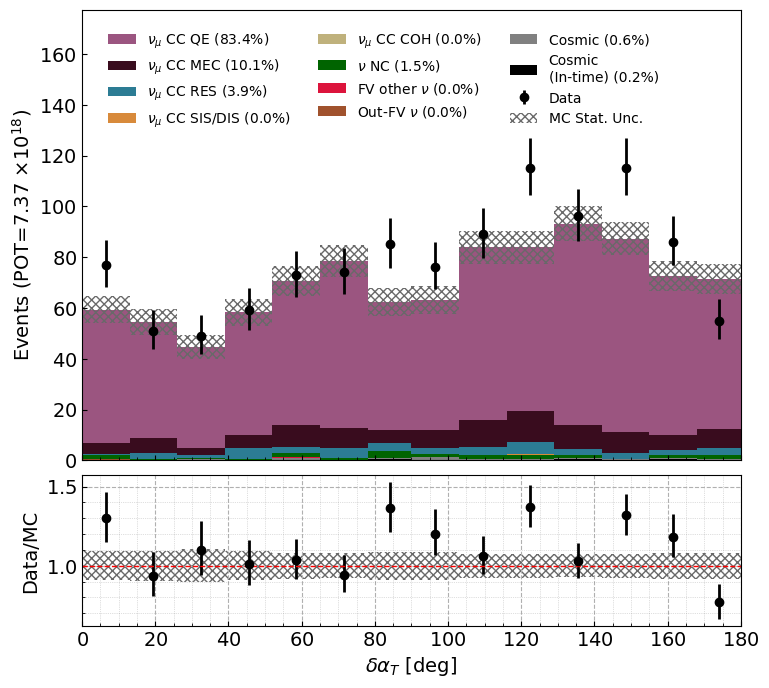

In [ ]:
# Muon z-direction
evtdf = mc_evt_df_mup
tki_name = "del_alpha"
var_config = VariableConfig.tki_del_alpha()
vardf = mc_ret_tki[tki_name] 
vardf_data = data_ret_tki[tki_name] 
vardf_intime = intime_ret_tki[tki_name]
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta \alpha_T$ [deg]",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

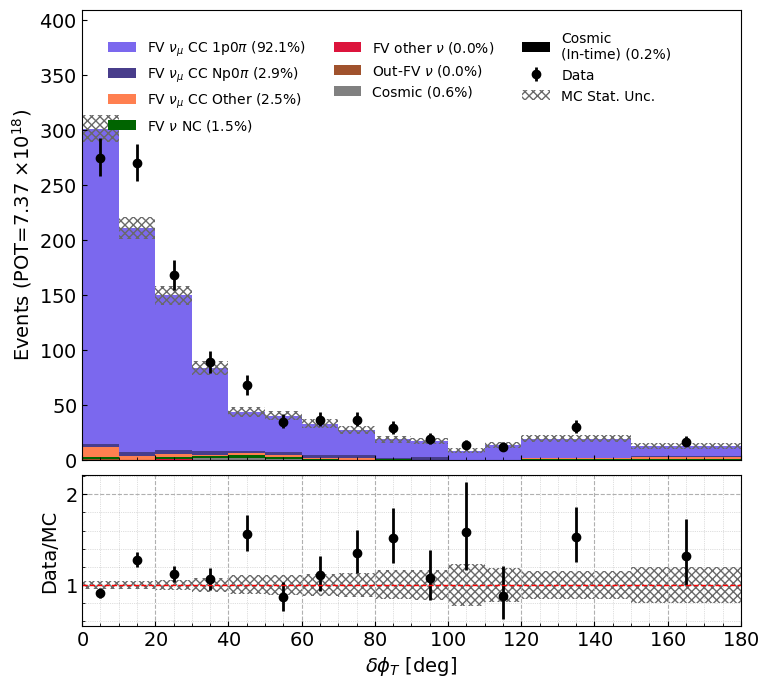

numu NC 31


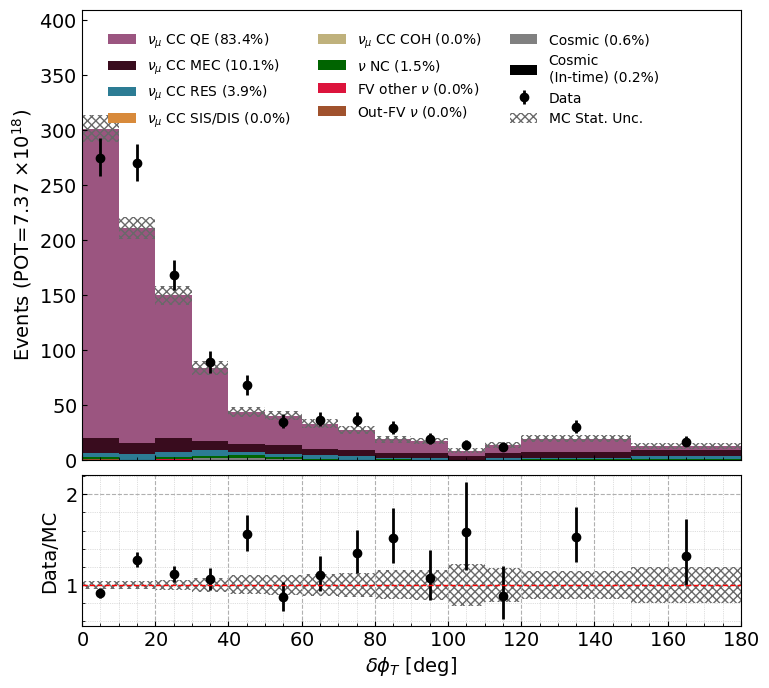

In [ ]:
# Muon z-direction
evtdf = mc_evt_df_mup
tki_name = "del_phi"
var_config = VariableConfig.tki_del_phi()
vardf = mc_ret_tki[tki_name] 
vardf_data = data_ret_tki[tki_name] 
vardf_intime = intime_ret_tki[tki_name]
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta \phi_T$ [deg]",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

## Data vs. MC of other variables

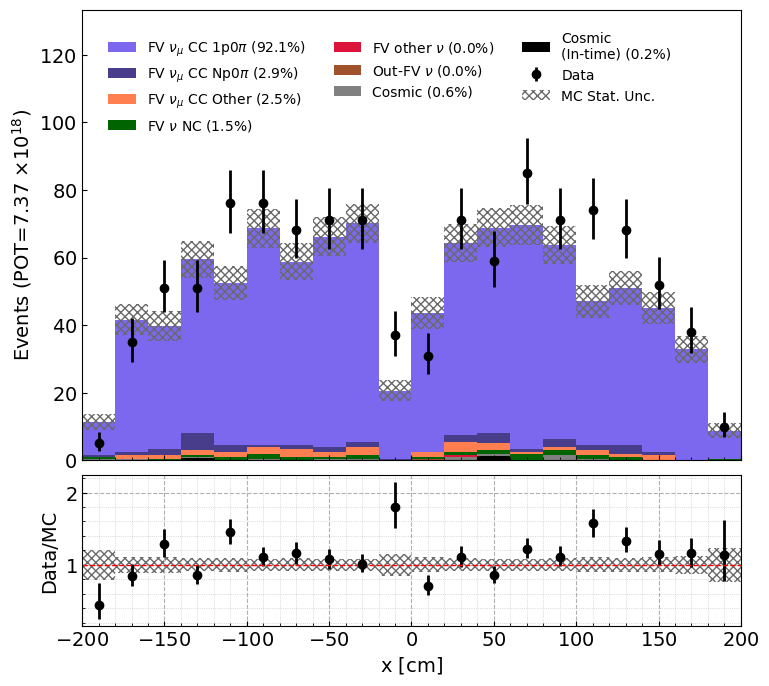

numu NC 31


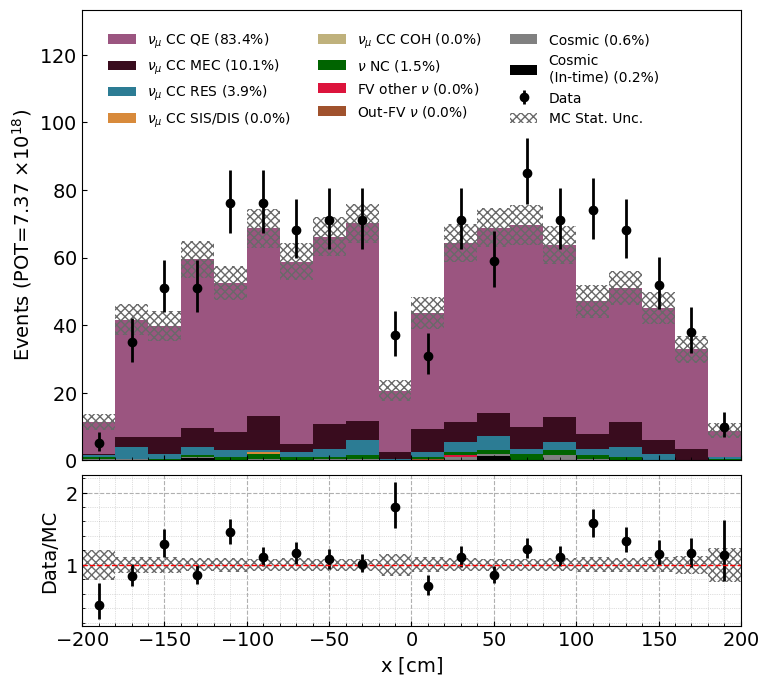

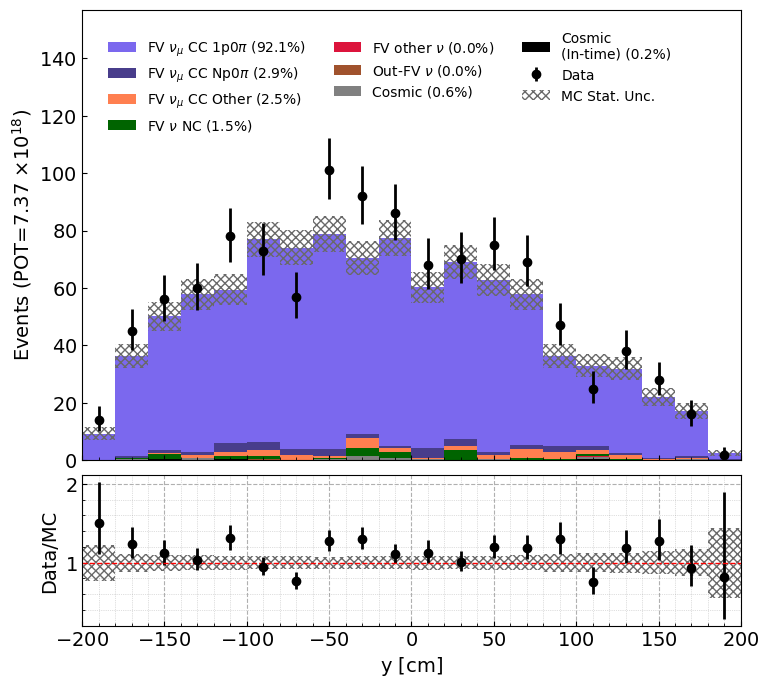

numu NC 31


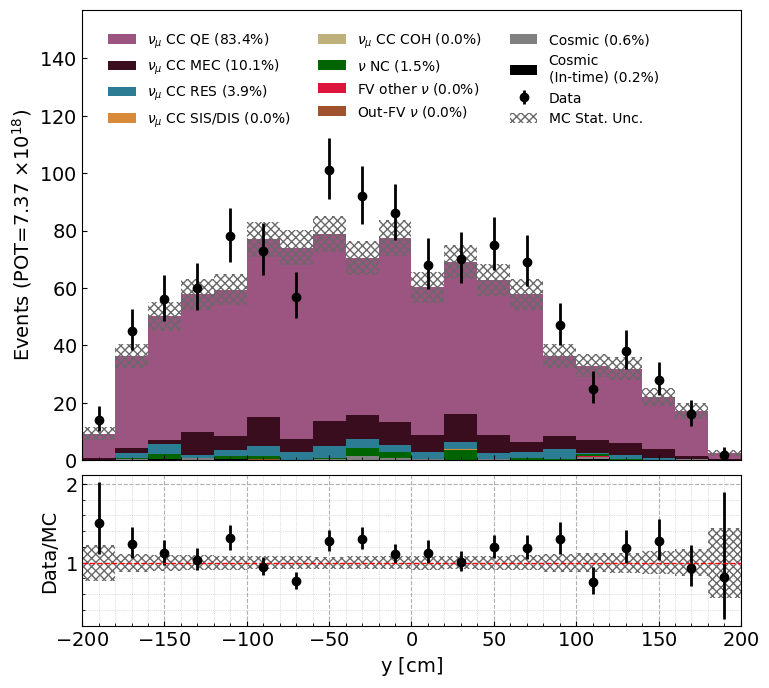

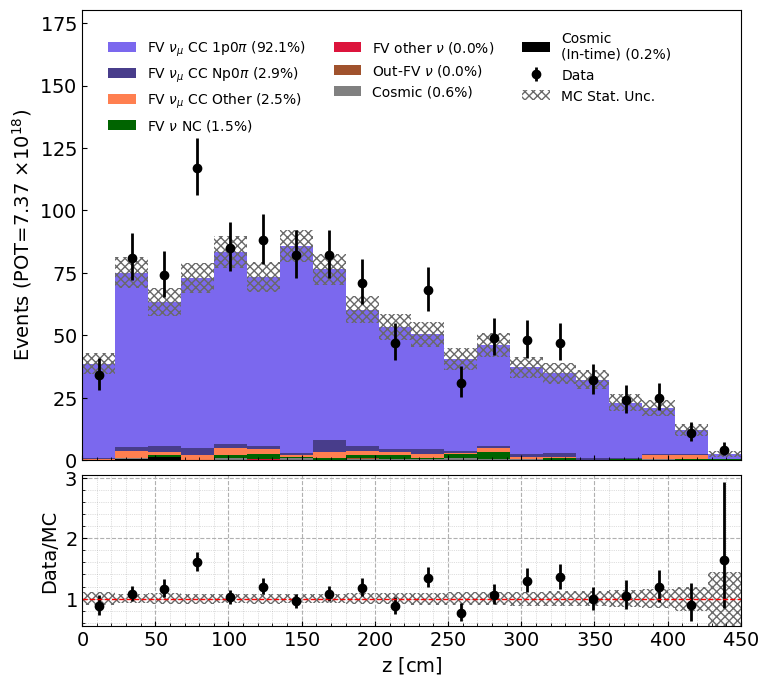

numu NC 31


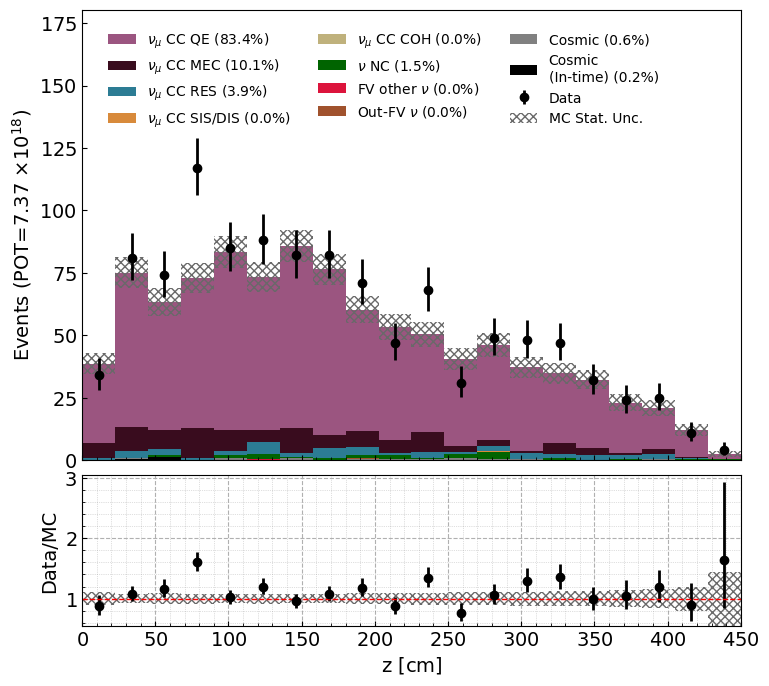

In [ ]:
# slice vertex position
evtdf = mc_evt_df_mup
vardf = evtdf.slc.vertex.x
vardf_data = data_evt_df_mup.slc.vertex.x
vardf_intime = intime_evt_df_mup.slc.vertex.x
bins = np.linspace(-200,200,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{x}$ [cm]", 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-slice_vertex_x_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-slice_vertex_x_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)


evtdf = mc_evt_df_mup
vardf = evtdf.slc.vertex.y
vardf_data = data_evt_df_mup.slc.vertex.y
vardf_intime = intime_evt_df_mup.slc.vertex.y
bins = np.linspace(-200,200,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{y}$ [cm]", 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-slice_vertex_y_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-slice_vertex_y_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)


evtdf = mc_evt_df_mup
vardf = evtdf.slc.vertex.z
vardf_data = data_evt_df_mup.slc.vertex.z
vardf_intime = intime_evt_df_mup.slc.vertex.z
bins = np.linspace(0,450,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{z}$ [cm]", 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-slice_vertex_z_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-slice_vertex_z_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

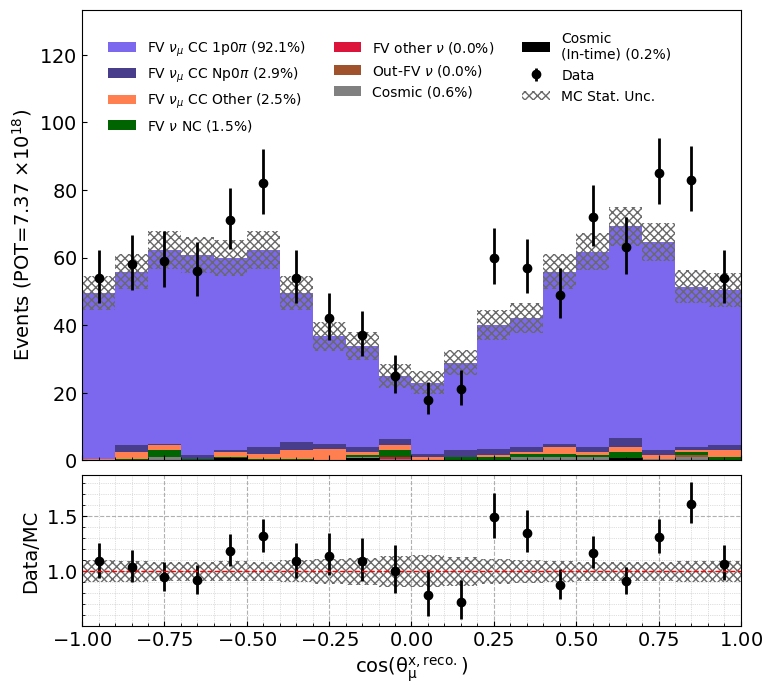

numu NC 31


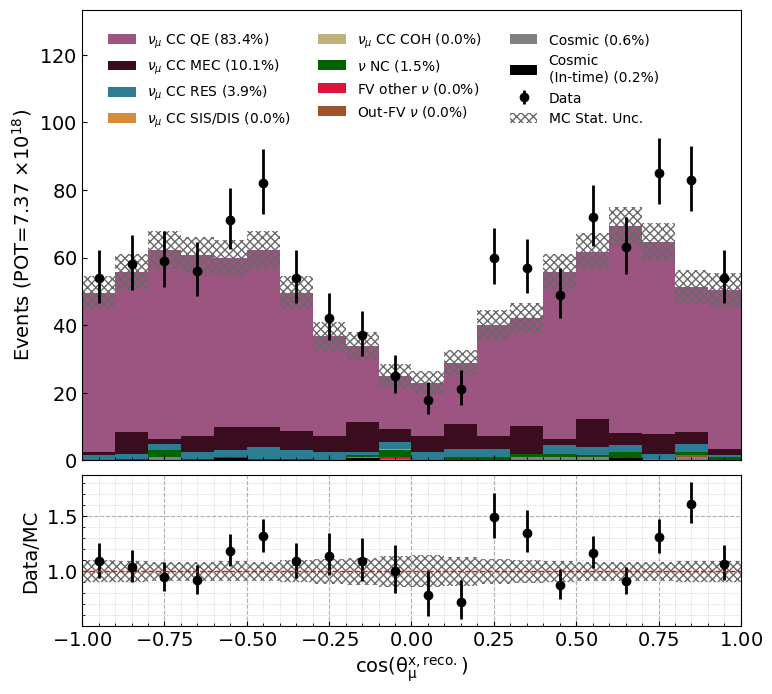

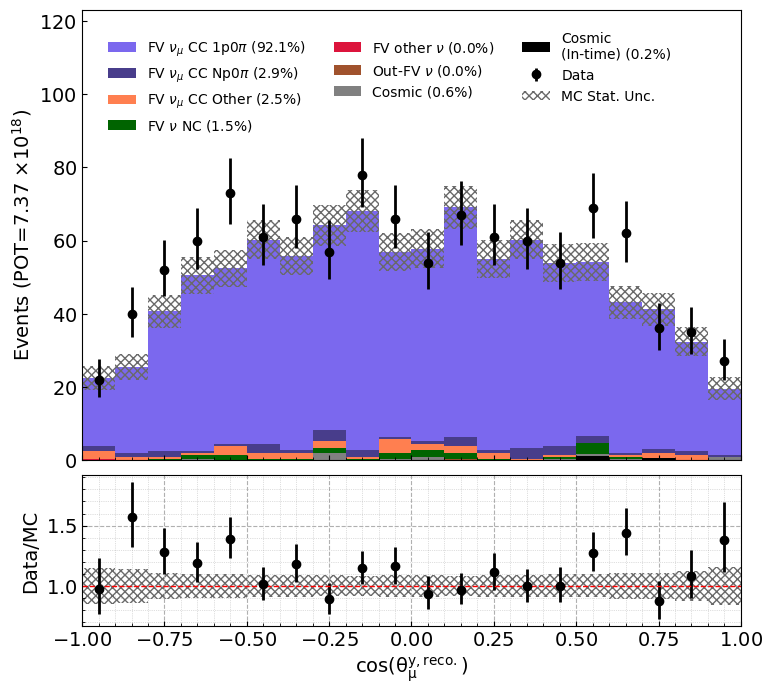

numu NC 31


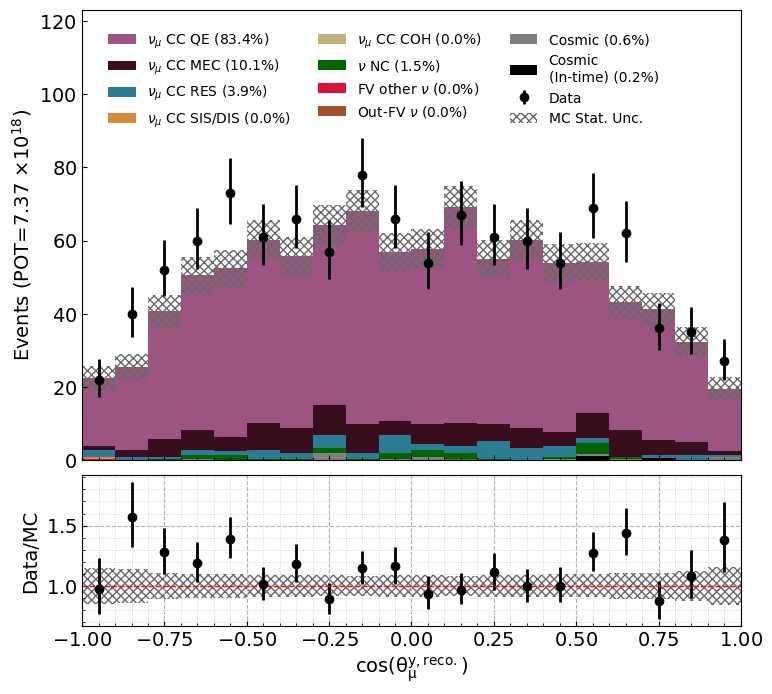

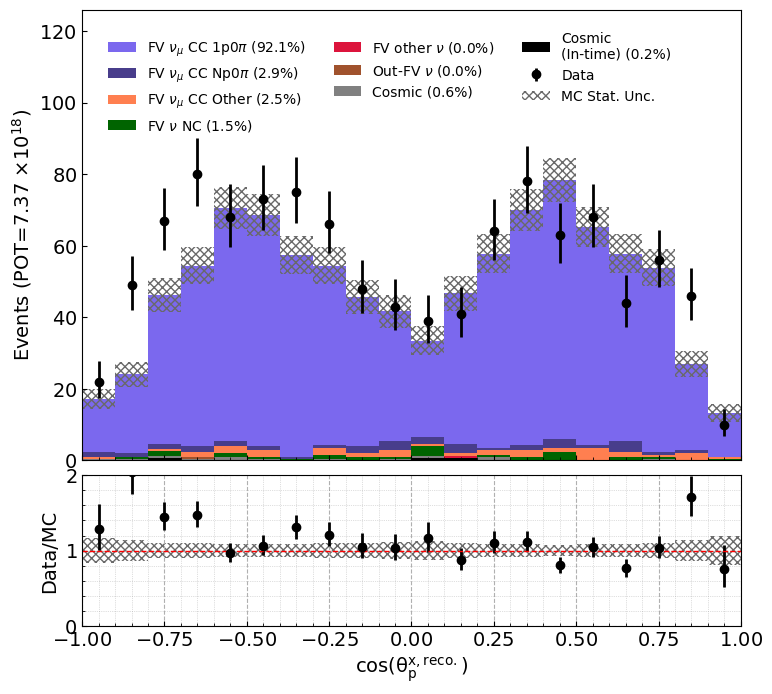

numu NC 31


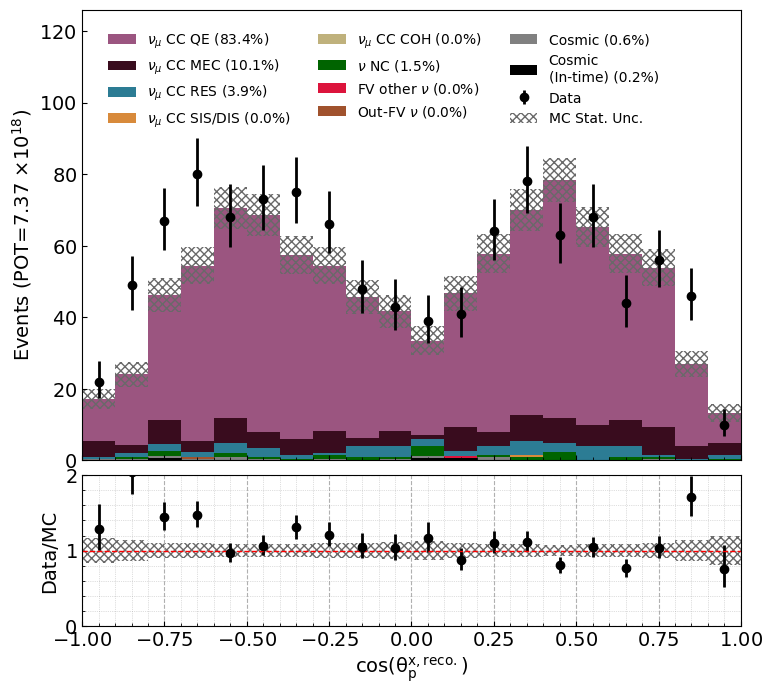

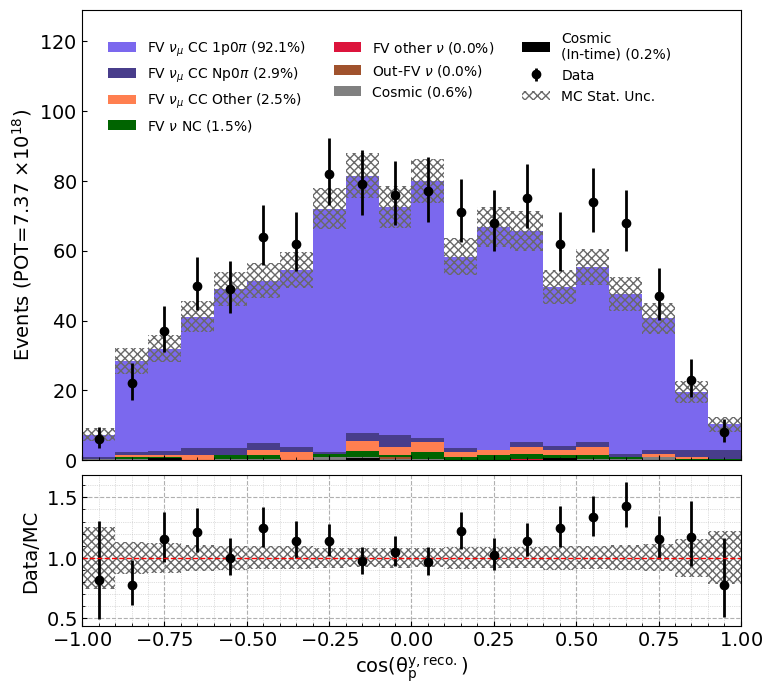

numu NC 31


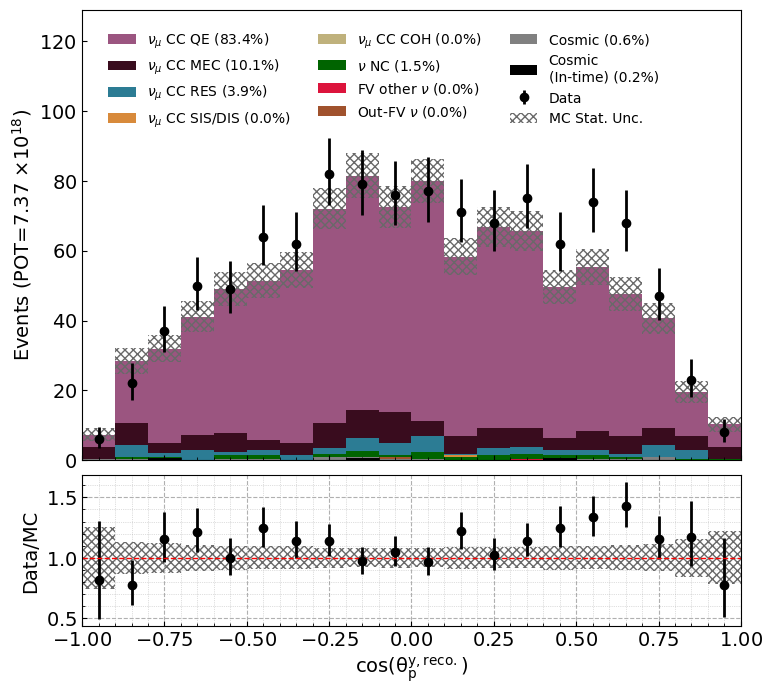

In [ ]:
# mu & p directions

evtdf = mc_evt_df_mup
vardf = mc_mu_df.pfp.trk.dir.x
vardf_data = data_mu_df.pfp.trk.dir.x
vardf_intime = intime_mu_df.pfp.trk.dir.x
bins = np.linspace(-1,1,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{cos(\theta_{\mu}^{x, reco.})}$",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

evtdf = mc_evt_df_mup
vardf = mc_mu_df.pfp.trk.dir.y
vardf_data = data_mu_df.pfp.trk.dir.y
vardf_intime = intime_mu_df.pfp.trk.dir.y
bins = np.linspace(-1,1,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{cos(\theta_{\mu}^{y, reco.})}$",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

# proton

evtdf = mc_evt_df_mup
vardf = mc_p_df.pfp.trk.dir.x
vardf_data = data_p_df.pfp.trk.dir.x
vardf_intime = intime_p_df.pfp.trk.dir.x
bins = np.linspace(-1,1,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{cos(\theta_p^{x, reco.})}$",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

evtdf = mc_evt_df_mup
vardf = mc_p_df.pfp.trk.dir.y
vardf_data = data_p_df.pfp.trk.dir.y
vardf_intime = intime_p_df.pfp.trk.dir.y
bins = np.linspace(-1,1,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{cos(\theta_p^{y, reco.})}$",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

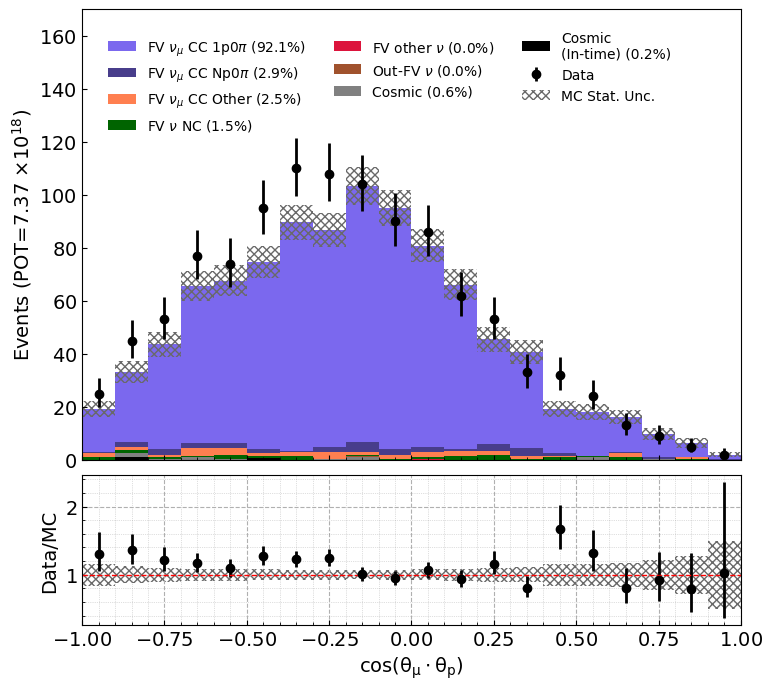

numu NC 31


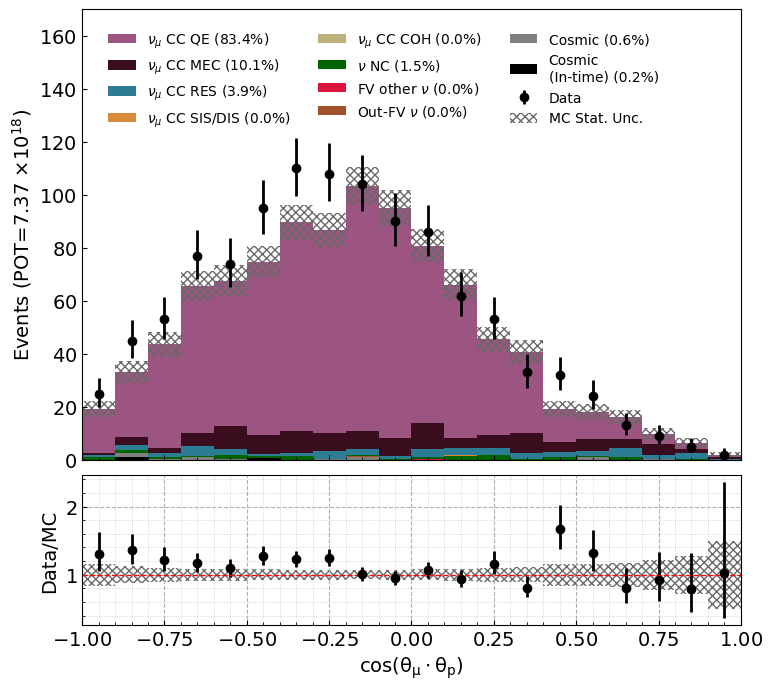

In [ ]:
# opening angle
evtdf = mc_evt_df_mup
vardf = mc_mu_df.pfp.trk.dir.x * mc_p_df.pfp.trk.dir.x + mc_mu_df.pfp.trk.dir.y * mc_p_df.pfp.trk.dir.y + mc_mu_df.pfp.trk.dir.z * mc_p_df.pfp.trk.dir.z
vardf_data = data_mu_df.pfp.trk.dir.x * data_p_df.pfp.trk.dir.x + data_mu_df.pfp.trk.dir.y * data_p_df.pfp.trk.dir.y + data_mu_df.pfp.trk.dir.z * data_p_df.pfp.trk.dir.z
vardf_intime = intime_mu_df.pfp.trk.dir.x * intime_p_df.pfp.trk.dir.x + intime_mu_df.pfp.trk.dir.y * intime_p_df.pfp.trk.dir.y + intime_mu_df.pfp.trk.dir.z * intime_p_df.pfp.trk.dir.z
bins = np.linspace(-1,1,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{cos(\theta_{\mu} \cdot \theta_p)}$", 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

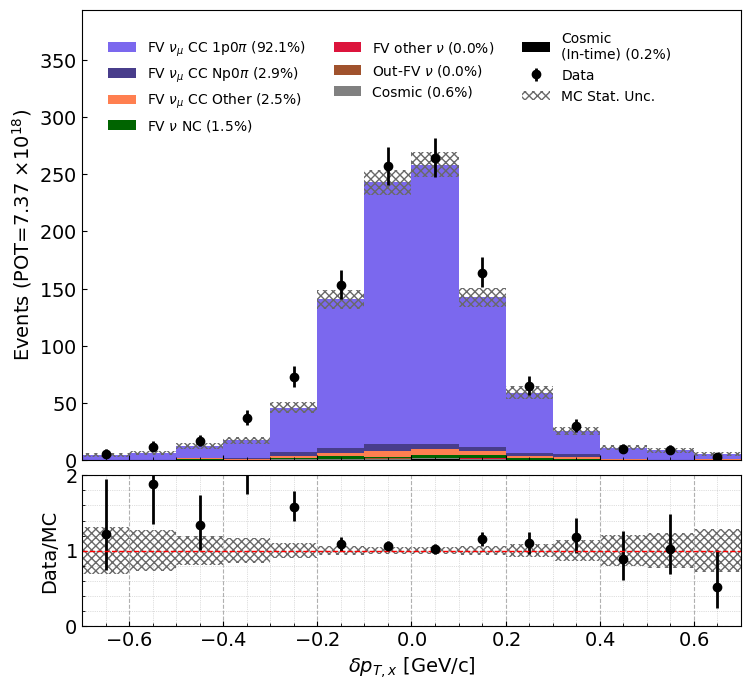

numu NC 31


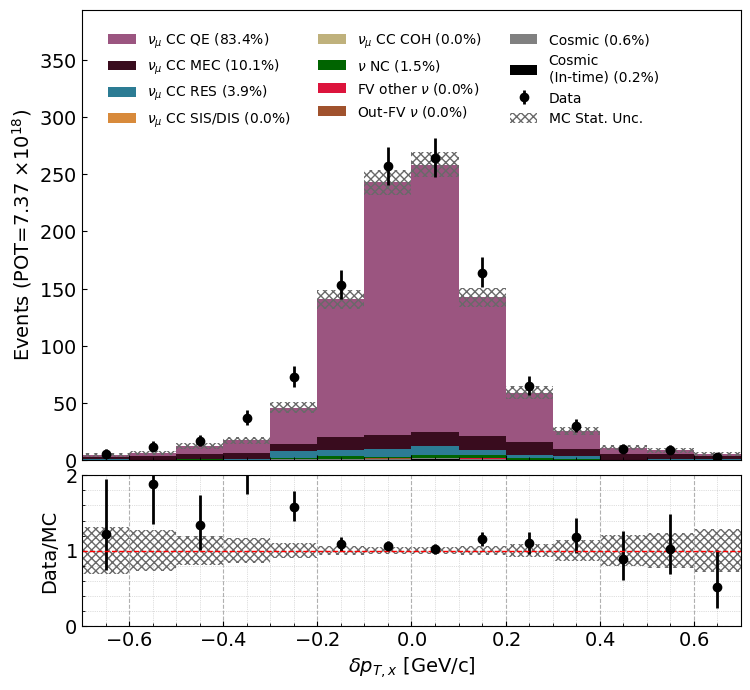

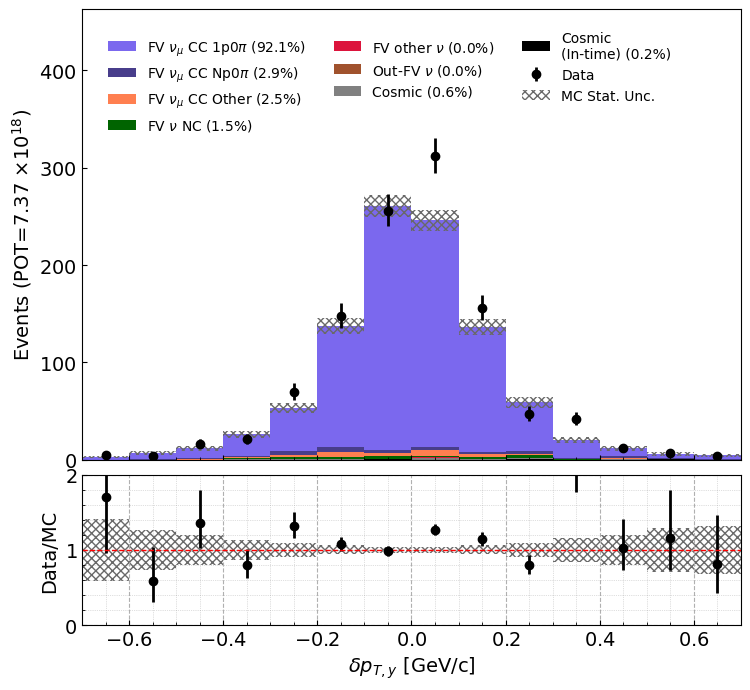

numu NC 31


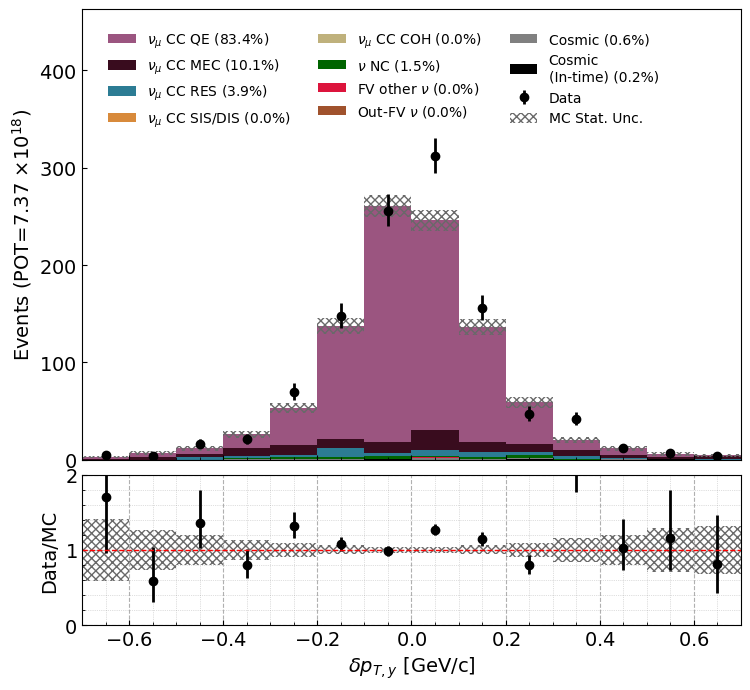

In [ ]:
# delta p_x, delta p_y
evtdf = mc_evt_df_mup
tki_name = "del_Tp_x"
var_config = VariableConfig.tki_del_Tp_x()
vardf = mc_ret_tki[tki_name]
vardf_data = data_ret_tki[tki_name]
vardf_intime = intime_ret_tki[tki_name]
bins = var_config.bins
bins = np.linspace(-0.7,0.7,15)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta p_{T,x}$ [GeV/c]",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

evtdf = mc_evt_df_mup
tki_name = "del_Tp_y"
var_config = VariableConfig.tki_del_Tp_y()
vardf = mc_ret_tki[tki_name]
vardf_data = data_ret_tki[tki_name]
vardf_intime = intime_ret_tki[tki_name]
# bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta p_{T,y}$ [GeV/c]",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/selected-tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/selected-tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)


In [ ]:
# Q2
# evtdf = mc_evt_df_mup

In [ ]:
# W

In [ ]:
# E_cal

# Summary

In [ ]:
stage_labels = [
    "All reconstructed slices",
    "Not clear cosmic",
    "Vertex in fiducial volume",
    "Nu-score > {}".format(nu_score_th),
    "Has exactly 2 PFPs",
    "Both PFPs contained",
    "Both PFPs have track score > {}".format(trackscore_th),
    "Both track \n(start position - vertex) < {} cm".format(dist_th),
    "One track is muon-like",
    "The other is proton-like"
]

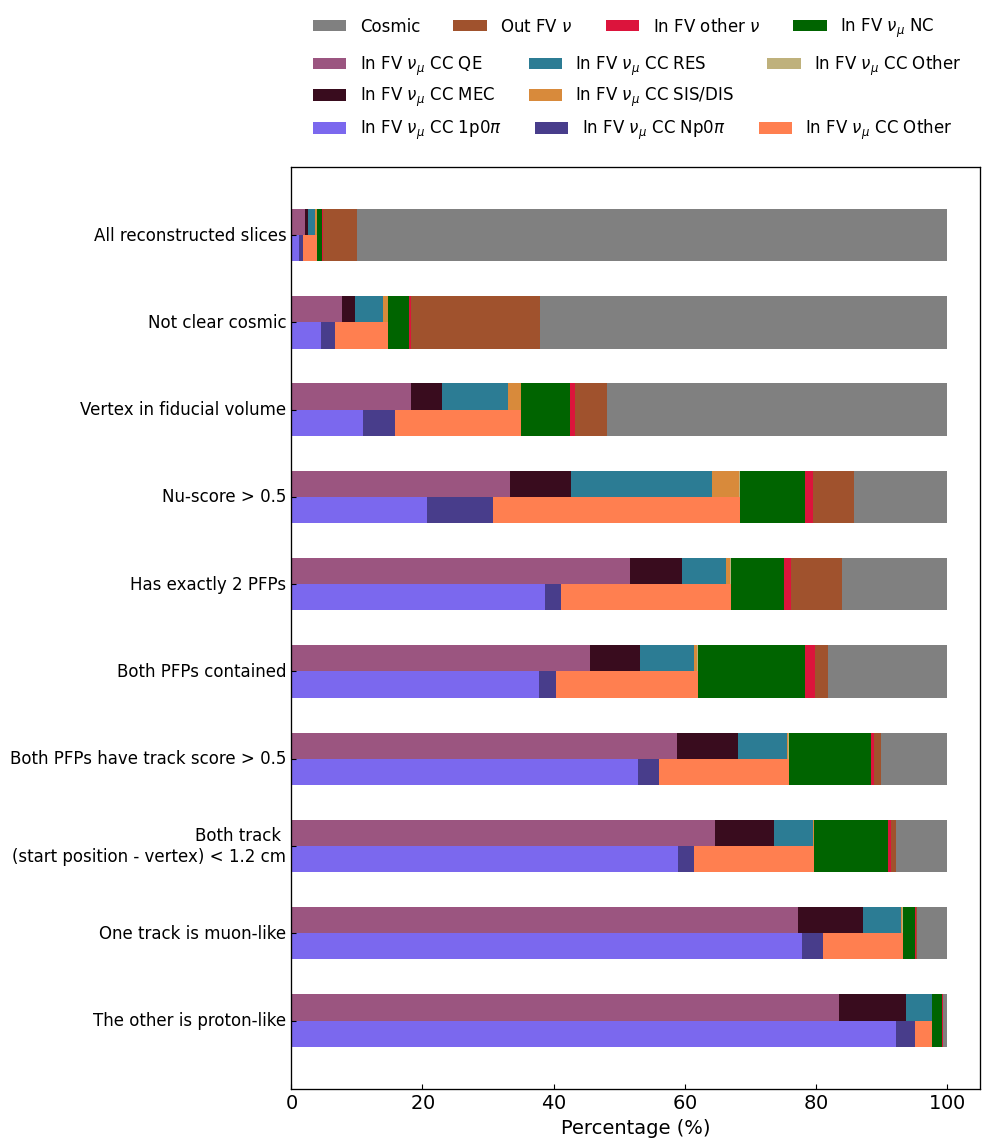

In [ ]:
# Patch
from matplotlib.patches import Patch


# Flip the order of stages
stages = list(perc_dict_topo.keys())[::-1]

# Number of stages
n_stages = len(stages)
bar_width = 0.3
y = np.arange(n_stages)

# Prepare data for topo and genie (in flipped order)
topo_data = np.array([perc_dict_topo[stage] for stage in stages])
genie_data = np.array([perc_dict_genie[stage] for stage in stages])

# Flip the stacked order: reverse the stack component axis
topo_data = topo_data[:, ::-1]
genie_data = genie_data[:, ::-1]
topology_colors_flipped = topology_colors
genie_colors_flipped = genie_mode_colors

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# For legend handles
topo_handles = []
genie_handles = []

# Stacked bars for topo (horizontal) - reversed stack order
left = np.zeros(n_stages)
for i in range(topo_data.shape[1]):
    color = topology_colors_flipped[i] if i < len(topology_colors_flipped) else None
    bar = ax.barh(
        y - bar_width/2,
        topo_data[:, i],
        bar_width,
        left=left,
        color=color,
        label=None if i > 0 else "Topology (unhatched)"
    )
    if i == 0:
        topo_handles.append(bar)
    left += topo_data[:, i]

# Stacked bars for genie (horizontal) - reversed stack order
left = np.zeros(n_stages)
for i in range(genie_data.shape[1]):
    color = genie_colors_flipped[i] if i < len(genie_colors_flipped) else None
    bar = ax.barh(
        y + bar_width/2,
        genie_data[:, i],
        bar_width,
        left=left,
        color=color,
        label=None if i > 0 else "GENIE (light hatch)"
    )
    if i == 0:
        genie_handles.append(bar)
    left += genie_data[:, i]

# Y-axis labels and ticks (flipped order)
ax.set_yticks(y)
ax.set_yticklabels(stage_labels[::-1], rotation=0, va='center', fontsize=12)

# X-axis label
ax.set_xlabel("Percentage (%)")

# ax.set_title("Selected Slice Breakdown")

# Custom legend: note in legend that unhatched is topology and hatched is genie
# from matplotlib.patches import Patch
# legend_handles = [
#     Patch(facecolor=topology_colors_flipped[0], label="Topology (unhatched)"),
#     Patch(facecolor=genie_colors_flipped[0], hatch='x', alpha=0.7, label="GENIE (light hatch)")
# ]
# ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.tight_layout()

common_handles = []
common_colors = ["gray", "sienna", "crimson", "darkgreen"]
common_modes = ["Cosmic", r"Out FV $\nu$", r"In FV other $\nu$", r"In FV $\nu_{\mu}$ NC"]
for i in range(len(common_colors)):
    common_handles.append(Patch(facecolor=common_colors[i], label=common_modes[i]))

genie_spec_handles = []
genie_spec_colors = ["#BFB17C", "#D88A3B", "#2c7c94", "#390C1E", "#9b5580"]
genie_spec_modes = [r"In FV $\nu_{\mu}$ CC Other", r"In FV $\nu_{\mu}$ CC SIS/DIS", r"In FV $\nu_{\mu}$ CC RES", r"In FV $\nu_{\mu}$ CC MEC", r"In FV $\nu_{\mu}$ CC QE"]
for i in range(len(genie_spec_colors)):
    genie_spec_handles.append(Patch(facecolor=genie_spec_colors[i], label=genie_spec_modes[i]))

topo_spec_handles = []
topo_spec_colors = ["coral", "darkslateblue", "mediumslateblue"]
topo_spec_modes = [r"In FV $\nu_{\mu}$ CC Other", r"In FV $\nu_{\mu}$ CC Np0$\pi$", r"In FV $\nu_{\mu}$ CC 1p0$\pi$"]
for i in range(len(topo_spec_colors)):
    topo_spec_handles.append(Patch(facecolor=topo_spec_colors[i], label=topo_spec_modes[i]))

ax.legend(handles=common_handles, loc='upper left', 
          bbox_to_anchor=(0.01, 1.18), ncol=4, fontsize=12, frameon=False)
ax_1 = ax.twinx()
ax_1.legend(handles=genie_spec_handles[::-1], loc='upper left', 
            bbox_to_anchor=(0.01, 1.14), ncol=3, fontsize=12, frameon=False)
ax_2 = ax.twinx()
ax_2.legend(handles=topo_spec_handles[::-1], loc='upper left', 
            bbox_to_anchor=(0.01, 1.07), ncol=4, fontsize=12, frameon=False)
ax_1.set_yticks([])
ax_2.set_yticks([])

save_name = save_fig_dir + "/summary-selected_slice_breakdown.png"
if save_fig:
    plt.savefig(save_name, dpi=300, bbox_inches="tight")

plt.show();

In [ ]:
# def eff_err(num, den):
#     """
#     Binomial statistical error on efficiency: sqrt(eff * (1-eff) / den)
#     where eff = num / den
#     """
#     eff = num / den
#     return np.sqrt(eff * (1 - eff) / den)

#     # sqrt(ε(1-ε)/n)

# def eff_err_prop(num_list, den_list):
#     err_list = []
#     for num, den in zip(num_list, den_list):
#         err_list.append(eff_err(num, den))
import statsmodels.api as sm

def eff_err(success,total):  # success/total
    err = [[],[]]
    eff = success/total
    for i in range(len(success)):
        this_success = success[i]
        this_tot = total[i]
        interval = sm.stats.proportion_confint(this_success,this_tot,method='wilson')
        err[0].append(abs(eff[i]-interval[0]))
        err[1].append(abs(eff[i]-interval[1]))
    return err

final purity: 92.26%


Text(0.5, 0, '$\\mathrm{P_\\mu}$ [GeV/c]')

Text(0, 0.5, 'Events')

Text(0, 0.5, 'Efficiency')

(0.0, 1.05)

(0.22, 1.0)

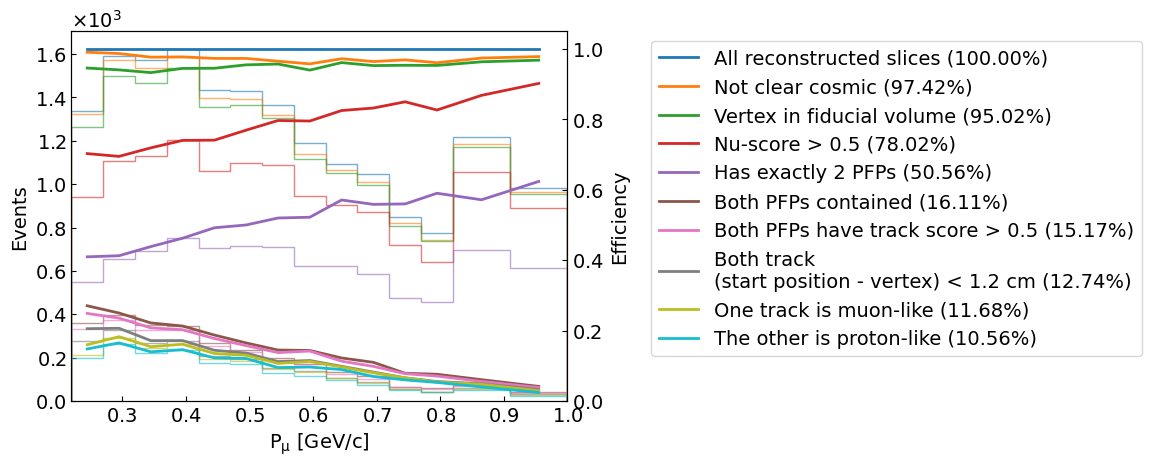

In [ ]:
# efficiency plot as a function of a variable
var_name = ("mu", "totp") 
var_config = VariableConfig.muon_momentum()
var_savename = var_config.var_save_name
xlabel = var_config.var_labels[0]
bins = var_config.bins

fig, ax = plt.subplots()
ax_eff = ax.twinx()
keys = df_dict.keys()
tot_evts = len(df_dict["allreco"][IsNuInFV_NumuCC_1p0pi(df_dict["allreco"])])
rate_list = []
for kidx, key in enumerate(keys):
    stage_df = df_dict[key]
    this_color = "C" + str(kidx)
    is_signal = IsNuInFV_NumuCC_1p0pi(stage_df)
    stage_df = stage_df[is_signal]
    if key == "2prong-mup":
        print("final purity: {:.2f}%".format(100 * len(stage_df) / len(df_dict["2prong-mup"])))
    vardf = stage_df[var_name]
    # append integrated efficiency to the label
    int_eff = len(stage_df) / tot_evts
    this_label = stage_labels[kidx] + " ({:.2f}%)".format(int_eff*100)
    n, bins, _ = ax.hist(vardf, bins=bins, histtype="step", label=this_label, alpha=0.6)
    if key == "allreco":
        tot_rate = n
    this_eff = n / tot_rate
    this_eff_err = eff_err(n, tot_rate)
    bin_centers = (bins[:-1] + bins[1:])/2
    ax_eff.plot(bin_centers, this_eff, label=this_label, color=this_color)
    # ax_eff.errorbar(bins[:-1], this_eff, yerr=this_eff_err, fmt="o", color=this_color)

ax.set_xlabel(xlabel)
ax.set_ylabel("Events")
ax_eff.set_ylabel("Efficiency")
ax_eff.set_ylim(0, 1.05)

# plt.axvline(mu_low_th, color="red", linestyle="--")
plt.xlim(bins[0], bins[-1])
plt.legend(bbox_to_anchor=(1.15, 1.0))
save_name = save_fig_dir + "/efficiency_plot_{}.png".format(var_savename)
if save_fig:
    plt.savefig(save_name, dpi=300, bbox_inches="tight")
plt.show()

final purity: 92.26%


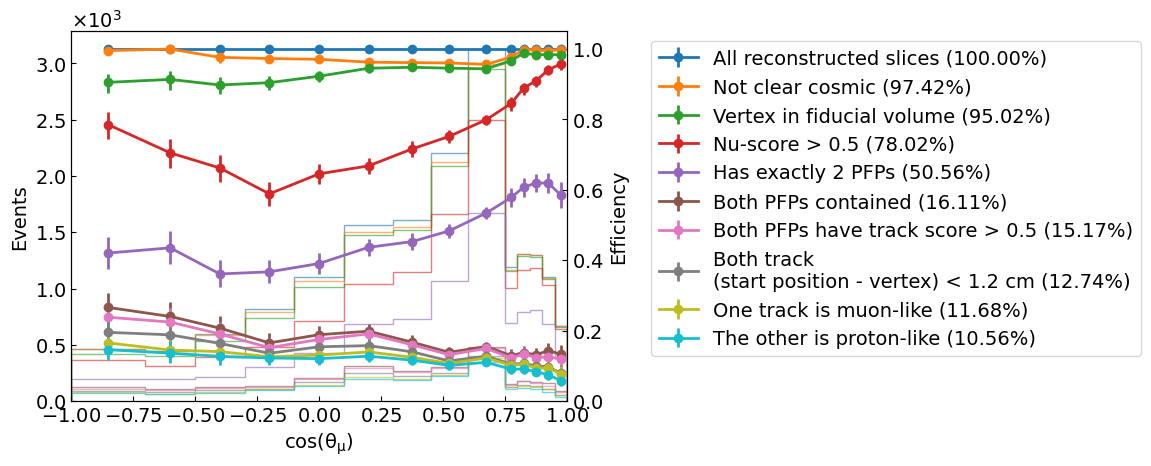

In [ ]:
# efficiency plot as a function of a variable
var_name = ("mu", "dir", "z") 
var_config = VariableConfig.muon_direction()
var_savename = var_config.var_save_name
xlabel = var_config.var_labels[0]
bins = var_config.bins

fig, ax = plt.subplots()
ax_eff = ax.twinx()
keys = df_dict.keys()
tot_evts = len(df_dict["allreco"][IsNuInFV_NumuCC_1p0pi(df_dict["allreco"])])
rate_list = []
for kidx, key in enumerate(keys):
    stage_df = df_dict[key]
    is_signal = IsNuInFV_NumuCC_1p0pi(stage_df)
    stage_df = stage_df[is_signal]
    if key == "2prong-mup":
        print("final purity: {:.2f}%".format(100 * len(stage_df) / len(df_dict["2prong-mup"])))
    vardf = stage_df[var_name]
    # append integrated efficiency to the label
    int_eff = len(stage_df) / tot_evts
    this_label = stage_labels[kidx] + " ({:.2f}%)".format(int_eff*100)
    n, bins, _ = ax.hist(vardf, bins=bins, histtype="step", label=this_label, alpha=0.6)
    if key == "allreco":
        tot_rate = n
    this_eff = n / tot_rate
    this_eff_err = eff_err(n, tot_rate)
    bin_centers = (bins[:-1] + bins[1:])/2
    # ax_eff.plot(bin_centers, this_eff, label=this_label)
    ax_eff.errorbar(bin_centers, this_eff, yerr=this_eff_err, fmt="o-", label=this_label) #, color=this_color)

ax.set_xlabel(xlabel)
ax.set_ylabel("Events")
ax_eff.set_ylabel("Efficiency")
ax_eff.set_ylim(0, 1.05)

# plt.axvline(mu_low_th, color="red", linestyle="--")
plt.xlim(bins[0], bins[-1])
plt.legend(bbox_to_anchor=(1.15, 1.0))
save_name = save_fig_dir + "/efficiency_plot_{}.png".format(var_savename)
if save_fig:
    plt.savefig(save_name, dpi=300, bbox_inches="tight")
plt.show();

final purity: 92.26%


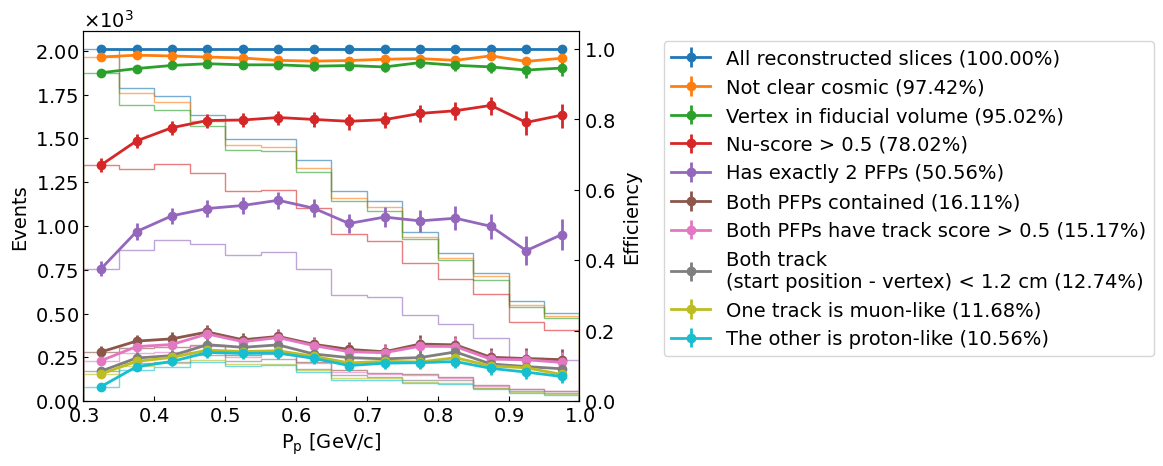

In [ ]:
var_name = ("p", "totp") 
var_config = VariableConfig.proton_momentum()
var_savename = var_config.var_save_name
xlabel = var_config.var_labels[0]
bins = var_config.bins

fig, ax = plt.subplots()
ax_eff = ax.twinx()
keys = df_dict.keys()
tot_evts = len(df_dict["allreco"][IsNuInFV_NumuCC_1p0pi(df_dict["allreco"])])
rate_list = []
for kidx, key in enumerate(keys):
    stage_df = df_dict[key]
    is_signal = IsNuInFV_NumuCC_1p0pi(stage_df)
    stage_df = stage_df[is_signal]
    if key == "2prong-mup":
        print("final purity: {:.2f}%".format(100 * len(stage_df) / len(df_dict["2prong-mup"])))
    vardf = stage_df[var_name]
    # append integrated efficiency to the label
    int_eff = len(stage_df) / tot_evts
    this_label = stage_labels[kidx] + " ({:.2f}%)".format(int_eff*100)
    n, bins, _ = ax.hist(vardf, bins=bins, histtype="step", label=this_label, alpha=0.6)
    if key == "allreco":
        tot_rate = n
    this_eff = n / tot_rate
    this_eff_err = eff_err(n, tot_rate)
    bin_centers = (bins[:-1] + bins[1:])/2
    # ax_eff.plot(bin_centers, this_eff, label=this_label)
    ax_eff.errorbar(bin_centers, this_eff, yerr=this_eff_err, fmt="o-", label=this_label) #, color=this_color)

ax.set_xlabel(xlabel)
ax.set_ylabel("Events")
ax_eff.set_ylabel("Efficiency")
ax_eff.set_ylim(0, 1.05)

# plt.axvline(p_low_th, color="red", linestyle="--")
plt.xlim(bins[0], bins[-1])
plt.legend(bbox_to_anchor=(1.15, 1.0))
save_name = save_fig_dir + "/efficiency_plot_{}.png".format(var_savename)
if save_fig:
    plt.savefig(save_name, dpi=300, bbox_inches="tight")
plt.show();

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

final purity: 92.26%


<ErrorbarContainer object of 3 artists>

Text(0.5, 0, '$\\mathrm{cos(\\theta_p)}$')

Text(0, 0.5, 'Events')

Text(0, 0.5, 'Efficiency')

(0.0, 1.05)

(-1.0, 1.0)

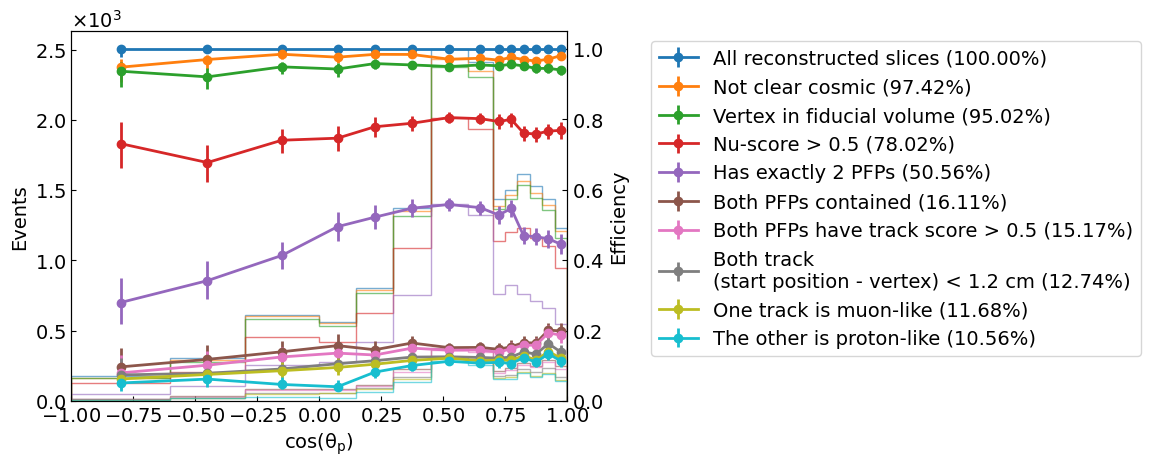

In [ ]:
# efficiency plot as a function of a variable
var_name = ("p", "dir", "z") 
var_config = VariableConfig.proton_direction()
var_savename = var_config.var_save_name
xlabel = var_config.var_labels[0]
bins = var_config.bins

fig, ax = plt.subplots()
ax_eff = ax.twinx()
keys = df_dict.keys()
tot_evts = len(df_dict["allreco"][IsNuInFV_NumuCC_1p0pi(df_dict["allreco"])])
rate_list = []
for kidx, key in enumerate(keys):
    stage_df = df_dict[key]
    is_signal = IsNuInFV_NumuCC_1p0pi(stage_df)
    stage_df = stage_df[is_signal]
    if key == "2prong-mup":
        print("final purity: {:.2f}%".format(100 * len(stage_df) / len(df_dict["2prong-mup"])))
    vardf = stage_df[var_name]
    # append integrated efficiency to the label
    int_eff = len(stage_df) / tot_evts
    this_label = stage_labels[kidx] + " ({:.2f}%)".format(int_eff*100)
    n, bins, _ = ax.hist(vardf, bins=bins, histtype="step", label=this_label, alpha=0.6)
    if key == "allreco":
        tot_rate = n
    this_eff = n / tot_rate
    this_eff_err = eff_err(n, tot_rate)
    bin_centers = (bins[:-1] + bins[1:])/2
    # ax_eff.plot(bin_centers, this_eff, label=this_label)
    ax_eff.errorbar(bin_centers, this_eff, yerr=this_eff_err, fmt="o-", label=this_label) #, color=this_color)
ax.set_xlabel(xlabel)
ax.set_ylabel("Events")
ax_eff.set_ylabel("Efficiency")
ax_eff.set_ylim(0, 1.05)

# plt.axvline(mu_low_th, color="red", linestyle="--")
plt.xlim(bins[0], bins[-1])
plt.legend(bbox_to_anchor=(1.15, 1.0))
save_name = save_fig_dir + "/efficiency_plot_{}.png".format(var_savename)
if save_fig:
    plt.savefig(save_name, dpi=300, bbox_inches="tight")
plt.show()

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

final purity: 92.26%


<ErrorbarContainer object of 3 artists>

Text(0.5, 0, '$\\delta p_T$ [GeV/c]')

Text(0, 0.5, 'Events')

Text(0, 0.5, 'Efficiency')

(0.0, 1.05)

(0.0, 1.0)

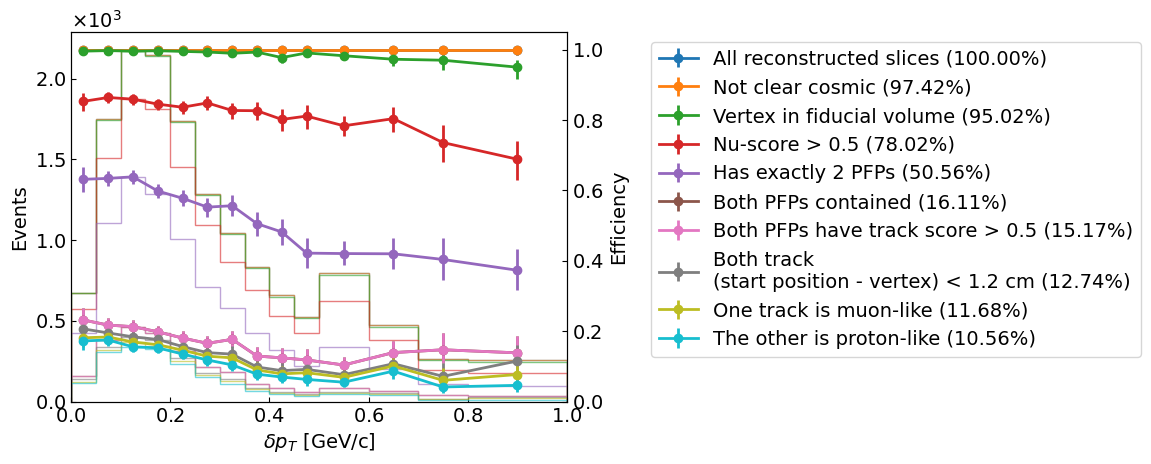

In [ ]:
# efficiency plot as a function of a variable
var_name = ("del_Tp", "", "") 
var_config = VariableConfig.tki_del_Tp()
var_savename = "del_Tp"
xlabel = r"$\delta p_T$ [GeV/c]"
bins = var_config.bins

fig, ax = plt.subplots()
ax_eff = ax.twinx()
keys = df_dict.keys()
tot_evts = len(df_dict["allreco"][IsNuInFV_NumuCC_1p0pi(df_dict["allreco"])])
rate_list = []
for kidx, key in enumerate(keys):
    stage_df = df_dict[key]
    is_signal = IsNuInFV_NumuCC_1p0pi(stage_df)
    stage_df = stage_df[is_signal]
    if key == "2prong-mup":
        print("final purity: {:.2f}%".format(100 * len(stage_df) / len(df_dict["2prong-mup"])))
    vardf = stage_df[var_name]
    # append integrated efficiency to the label
    int_eff = len(stage_df) / tot_evts
    this_label = stage_labels[kidx] + " ({:.2f}%)".format(int_eff*100)
    n, bins, _ = ax.hist(vardf, bins=bins, histtype="step", label=this_label, alpha=0.6)
    if key == "allreco":
        tot_rate = n
    this_eff = n / tot_rate
    this_eff_err = eff_err(n, tot_rate)
    bin_centers = (bins[:-1] + bins[1:])/2
    # ax_eff.plot(bin_centers, this_eff, label=this_label)
    ax_eff.errorbar(bin_centers, this_eff, yerr=this_eff_err, fmt="o-", label=this_label) #, color=this_color)

ax.set_xlabel(xlabel)
ax.set_ylabel("Events")
ax_eff.set_ylabel("Efficiency")
ax_eff.set_ylim(0, 1.05)

# plt.axvline(mu_low_th, color="red", linestyle="--")
plt.xlim(bins[0], bins[-1])
plt.legend(bbox_to_anchor=(1.15, 1.0))
save_name = save_fig_dir + "/efficiency_plot_{}.png".format(var_savename)
if save_fig:
    plt.savefig(save_name, dpi=300, bbox_inches="tight")
plt.show()

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

final purity: 92.26%


<ErrorbarContainer object of 3 artists>

Text(0.5, 0, '$\\delta p$ [GeV/c]')

Text(0, 0.5, 'Events')

Text(0, 0.5, 'Efficiency')

(0.0, 1.05)

(0.0, 1.0)

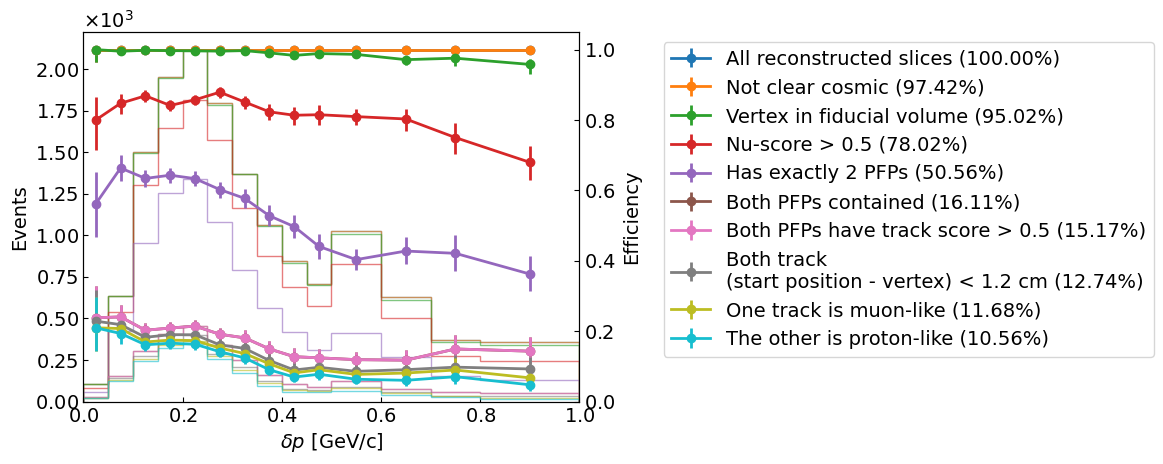

In [ ]:
# efficiency plot as a function of a variable
var_name = ("del_p", "", "") 
var_config = VariableConfig.tki_del_Tp()
var_savename = "del_p"
xlabel = r"$\delta p$ [GeV/c]"
bins = var_config.bins

fig, ax = plt.subplots()
ax_eff = ax.twinx()
keys = df_dict.keys()
tot_evts = len(df_dict["allreco"][IsNuInFV_NumuCC_1p0pi(df_dict["allreco"])])
rate_list = []
for kidx, key in enumerate(keys):
    stage_df = df_dict[key]
    is_signal = IsNuInFV_NumuCC_1p0pi(stage_df)
    stage_df = stage_df[is_signal]
    if key == "2prong-mup":
        print("final purity: {:.2f}%".format(100 * len(stage_df) / len(df_dict["2prong-mup"])))
    vardf = stage_df[var_name]
    # append integrated efficiency to the label
    int_eff = len(stage_df) / tot_evts
    this_label = stage_labels[kidx] + " ({:.2f}%)".format(int_eff*100)
    n, bins, _ = ax.hist(vardf, bins=bins, histtype="step", label=this_label, alpha=0.6)
    if key == "allreco":
        tot_rate = n
    this_eff = n / tot_rate
    this_eff_err = eff_err(n, tot_rate)
    bin_centers = (bins[:-1] + bins[1:])/2
    # ax_eff.plot(bin_centers, this_eff, label=this_label)
    ax_eff.errorbar(bin_centers, this_eff, yerr=this_eff_err, fmt="o-", label=this_label) #, color=this_color)
ax.set_xlabel(xlabel)
ax.set_ylabel("Events")
ax_eff.set_ylabel("Efficiency")
ax_eff.set_ylim(0, 1.05)

# plt.axvline(mu_low_th, color="red", linestyle="--")
plt.xlim(bins[0], bins[-1])
plt.legend(bbox_to_anchor=(1.15, 1.0))
save_name = save_fig_dir + "/efficiency_plot_{}.png".format(var_savename)
if save_fig:
    plt.savefig(save_name, dpi=300, bbox_inches="tight")
plt.show()

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

final purity: 92.26%


<ErrorbarContainer object of 3 artists>

Text(0.5, 0, '$\\delta \\alpha$ [rad]')

Text(0, 0.5, 'Events')

Text(0, 0.5, 'Efficiency')

(0.0, 1.05)

(0.0, 180.0)

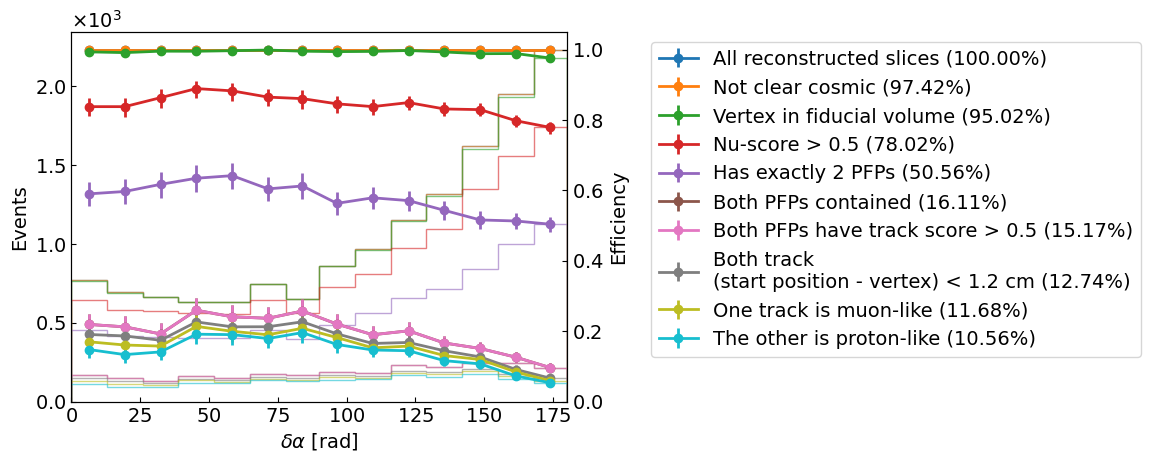

In [ ]:
# efficiency plot as a function of a variable
var_name = ("del_alpha", "", "") 
var_config = VariableConfig.tki_del_alpha()
var_savename = "del_alpha"
xlabel = r"$\delta \alpha$ [rad]"
bins = var_config.bins

fig, ax = plt.subplots()
ax_eff = ax.twinx()
keys = df_dict.keys()
tot_evts = len(df_dict["allreco"][IsNuInFV_NumuCC_1p0pi(df_dict["allreco"])])
rate_list = []
for kidx, key in enumerate(keys):
    stage_df = df_dict[key]
    is_signal = IsNuInFV_NumuCC_1p0pi(stage_df)
    stage_df = stage_df[is_signal]
    if key == "2prong-mup":
        print("final purity: {:.2f}%".format(100 * len(stage_df) / len(df_dict["2prong-mup"])))
    vardf = stage_df[var_name]
    # append integrated efficiency to the label
    int_eff = len(stage_df) / tot_evts
    this_label = stage_labels[kidx] + " ({:.2f}%)".format(int_eff*100)
    n, bins, _ = ax.hist(vardf, bins=bins, histtype="step", label=this_label, alpha=0.6)
    if key == "allreco":
        tot_rate = n
    this_eff = n / tot_rate
    this_eff_err = eff_err(n, tot_rate)
    bin_centers = (bins[:-1] + bins[1:])/2
    # ax_eff.plot(bin_centers, this_eff, label=this_label)
    ax_eff.errorbar(bin_centers, this_eff, yerr=this_eff_err, fmt="o-", label=this_label) #, color=this_color)

ax.set_xlabel(xlabel)
ax.set_ylabel("Events")
ax_eff.set_ylabel("Efficiency")
ax_eff.set_ylim(0, 1.05)

# plt.axvline(mu_low_th, color="red", linestyle="--")
plt.xlim(bins[0], bins[-1])
plt.legend(bbox_to_anchor=(1.15, 1.0))
save_name = save_fig_dir + "/efficiency_plot_{}.png".format(var_savename)
if save_fig:
    plt.savefig(save_name, dpi=300, bbox_inches="tight")
plt.show()

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

final purity: 92.26%


<ErrorbarContainer object of 3 artists>

Text(0.5, 0, '$\\delta \\phi$ [rad]')

Text(0, 0.5, 'Events')

Text(0, 0.5, 'Efficiency')

(0.0, 1.05)

(0.0, 180.0)

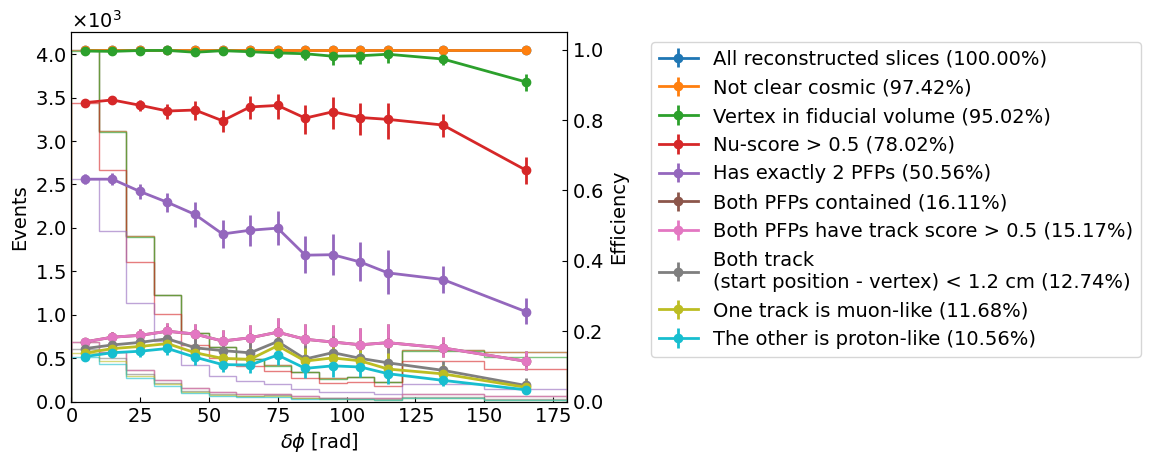

In [ ]:
# efficiency plot as a function of a variable
var_name = ("del_phi", "", "") 
var_config = VariableConfig.tki_del_phi()
var_savename = "del_phi"
xlabel = r"$\delta \phi$ [rad]"
bins = var_config.bins

fig, ax = plt.subplots()
ax_eff = ax.twinx()
keys = df_dict.keys()
tot_evts = len(df_dict["allreco"][IsNuInFV_NumuCC_1p0pi(df_dict["allreco"])])
rate_list = []
for kidx, key in enumerate(keys):
    stage_df = df_dict[key]
    is_signal = IsNuInFV_NumuCC_1p0pi(stage_df)
    stage_df = stage_df[is_signal]
    if key == "2prong-mup":
        print("final purity: {:.2f}%".format(100 * len(stage_df) / len(df_dict["2prong-mup"])))
    vardf = stage_df[var_name]
    # append integrated efficiency to the label
    int_eff = len(stage_df) / tot_evts
    this_label = stage_labels[kidx] + " ({:.2f}%)".format(int_eff*100)
    n, bins, _ = ax.hist(vardf, bins=bins, histtype="step", label=this_label, alpha=0.6)
    if key == "allreco":
        tot_rate = n
    this_eff = n / tot_rate
    this_eff_err = eff_err(n, tot_rate)
    bin_centers = (bins[:-1] + bins[1:])/2
    # ax_eff.plot(bin_centers, this_eff, label=this_label)
    ax_eff.errorbar(bin_centers, this_eff, yerr=this_eff_err, fmt="o-", label=this_label) #, color=this_color)

ax.set_xlabel(xlabel)
ax.set_ylabel("Events")
ax_eff.set_ylabel("Efficiency")
ax_eff.set_ylim(0, 1.05)

# plt.axvline(mu_low_th, color="red", linestyle="--")
plt.xlim(bins[0], bins[-1])
plt.legend(bbox_to_anchor=(1.15, 1.0))
save_name = save_fig_dir + "/efficiency_plot_{}.png".format(var_savename)
if save_fig:
    plt.savefig(save_name, dpi=300, bbox_inches="tight")
plt.show()